In [2]:
# Load basic libraries for economic analysis and data manipulation, visualization, and statistical modeling.
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.api as tsa
import statsmodels.tsa.stattools as tsastat
import statsmodels.tsa.statespace.api as smtss
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.graphics.gofplots as smgof
import wbgapi as wb

# Define the tiers with country names
tier_1 = {
    "Paraguay": "PRY",
    "El Salvador": "SLV",
    "Nicaragua": "NIC",
    "Serbia": "SRB",
    "Bulgaria": "BGR",
    "Lao PDR": "LAO",
    "Lebanon": "LBN",
    "Kyrgyz Republic": "KGZ"
}

tier_2 = {
    "Peru": "PER",
    "Malaysia": "MYS",
    "Ghana": "GHA",
    "Mozambique": "MOZ",
    "Angola": "AGO",
    "Nepal": "NPL",
    "Venezuela, RB": "VEN",
    "Zambia": "ZMB",
    "Sri Lanka": "LKA",
    "Mali": "MLI"
}

tier_3 = {
    "Argentina": "ARG",
    "Algeria": "DZA",
    "Iraq": "IRQ",
    "Morocco": "MAR",
    "Kenya": "KEN",
    "South Africa": "ZAF",
    "Myanmar": "MMR",
    "Colombia": "COL",
    "Uzbekistan": "UZB"
}

tier_4 = {
    "Egypt, Arab Rep.": "EGY",
    "Ethiopia": "ETH",
    "PhiliPPInes": "PHL",
    "Vietnam": "VNM",
    "Iran, Islamic Rep.": "IRN",
    "Turkey": "TUR"
}

# Combine all countries
all_countries = {**tier_1, **tier_2, **tier_3, **tier_4}
country_codes = list(all_countries.values())

# Year range
start_year = 2005
end_year = 2023
time_range = range(start_year, end_year + 1)

# EXPANDED WDI indicators for infrastructure investment research
wdi_indicator_names = {
    # ORIGINAL INDICATORS
    "SP.POP.TOTL": "Population_total",
    "NE.GDI.TOTL.ZS": "Gross_Capital_Formation_pct_GDP",
    "EG.ELC.ACCS.ZS": "Access_to_Electricity_pct",
    "NY.GDP.MKTP.KD": "GDP_constant_2015_USD",
    "NY.GDP.MKTP.CD": "GDP_current_USD",
    "SI.POV.GINI": "GINI_Index",
    "BX.KLT.DINV.WD.GD.ZS": "FDI_Inflows_pct_GDP",
    "GC.TAX.YPKG.ZS": "Taxes_on_Income_Profits_CapitalGains_pct_revenue",
    "IT.NET.USER.ZS": "Individuals_using_Internet_pct",
    
    # MACROECONOMIC INDICATORS (Critical additions)
    "NY.GDP.PCAP.KD": "GDP_per_capita_constant_2015_USD",
    "NY.GDP.MKTP.KD.ZG": "GDP_growth_annual_pct",
    "FP.CPI.TOTL.ZG": "Inflation_consumer_prices_annual_pct",
    "NE.EXP.GNFS.ZS": "Exports_goods_services_pct_GDP",
    "NE.IMP.GNFS.ZS": "Imports_goods_services_pct_GDP",
    "BN.CAB.XOKA.GD.ZS": "Current_account_balance_pct_GDP",
    
    # FINANCIAL DEVELOPMENT (Critical for H2 - barriers to investment)
    "FS.AST.PRVT.GD.ZS": "Domestic_credit_to_private_sector_pct_GDP",
    "CM.MKT.LCAP.GD.ZS": "Market_capitalization_pct_GDP",
    "FR.INR.LNDP": "Lending_interest_rate_pct",
    "FR.INR.DPST": "Deposit_interest_rate_pct",
    
    # FISCAL INDICATORS (Important for government capacity)
    "GC.DOD.TOTL.GD.ZS": "Central_government_debt_pct_GDP",
    "GC.TAX.TOTL.GD.ZS": "Tax_revenue_pct_GDP",
    "GC.XPN.TOTL.GD.ZS": "Government_expenditure_pct_GDP",
    
    # EXTERNAL DEBT & RISK (Important for H2)
    "DT.DOD.DECT.GD.ZS": "External_debt_stocks_pct_GNI",
    "DT.TDS.DECT.EX.ZS": "Total_debt_service_pct_exports",
    
    # INFRASTRUCTURE INDICATORS (for sector analysis H3)
    "IT.CEL.SETS.P2": "Mobile_cellular_subscriptions_per_100",
    "IT.NET.BBND.P2": "Fixed_broadband_subscriptions_per_100",
    "IS.ROD.PAVE.ZS": "Roads_paved_pct_total",
    "EG.ELC.LOSS.ZS": "Electric_power_transmission_losses_pct",
    "EG.USE.ELEC.KH.PC": "Electric_power_consumption_kWh_per_capita",
    
    # TRADE & OPENNESS (Additional controls)
    "NE.TRD.GNFS.ZS": "Trade_pct_GDP",
    "BX.KLT.DINV.CD.WD": "FDI_net_inflows_current_USD",
    
    # HUMAN CAPITAL (Additional controls)
    "SE.TER.ENRR": "Tertiary_education_enrollment_pct_gross",
    "SE.XPD.TOTL.GD.ZS": "Education_expenditure_pct_GDP",
    
    # URBANIZATION (Infrastructure demand proxy)
    "SP.URB.TOTL.IN.ZS": "Urban_population_pct_total"
}

# WGI indicators (the 6 standard dimensions) - CRITICAL FOR H1
wgi_indicator_names = {
    "PV.PER.RNK": "Political_Stability_percentile",
    "GE.PER.RNK": "Government_Effectiveness_percentile",
    "RQ.PER.RNK": "Regulatory_Quality_percentile",
    "RL.PER.RNK": "Rule_of_Law_percentile",
    "CC.PER.RNK": "Control_of_Corruption_percentile",
    "VA.PER.RNK": "Voice_and_Accountability_percentile"
}

print("="*80)
print("FETCHING WORLD BANK DATA FOR INFRASTRUCTURE INVESTMENT ANALYSIS")
print("="*80)
print(f"\nCountries: {len(country_codes)}")
print(f"Time period: {start_year}-{end_year}")
print(f"WDI Indicators: {len(wdi_indicator_names)}")
print(f"WGI Indicators: {len(wgi_indicator_names)}")
print(f"Total Indicators: {len(wdi_indicator_names) + len(wgi_indicator_names)}")

print("\n" + "="*80)
print("Fetching WDI data...")
print("="*80)
wdi_data_raw = wb.data.DataFrame(
    list(wdi_indicator_names.keys()),
    country_codes,
    time=time_range,
    labels=True,
    numericTimeKeys=True
)
print(f"✓ WDI data fetched: {wdi_data_raw.shape}")

print("\n" + "="*80)
print("Fetching WGI data...")
print("="*80)
wgi_data_raw = wb.data.DataFrame(
    list(wgi_indicator_names.keys()),
    country_codes,
    time=time_range,
    labels=True,
    numericTimeKeys=True,
    db=3
)
print(f"✓ WGI data fetched: {wgi_data_raw.shape}")

# Process WDI data
print("\n" + "="*80)
print("Processing WDI data...")
print("="*80)
wdi_data_raw = wdi_data_raw.reset_index()

# Check actual column names
print(f"Columns after reset_index: {wdi_data_raw.columns.tolist()[:10]}...")

# Identify the country and series columns (they might have different names)
country_col = None
series_col = None

for col in ['country', 'economy', 'Country', 'Economy']:
    if col in wdi_data_raw.columns:
        country_col = col
        break

for col in ['series', 'indicator', 'Series', 'Indicator']:
    if col in wdi_data_raw.columns:
        series_col = col
        break

print(f"Country column: '{country_col}'")
print(f"Series column: '{series_col}'")

# Get year columns (numeric columns)
year_cols = [col for col in wdi_data_raw.columns 
             if col not in [country_col, series_col, 'Country', 'Series'] 
             and (isinstance(col, (int, np.integer)) or (isinstance(col, str) and col.isdigit()))]
print(f"Year columns found: {len(year_cols)}")
if year_cols:
    print(f"Year range: {min(year_cols)} to {max(year_cols)}")

# Melt to long format using the actual column names
wdi_long = wdi_data_raw.melt(
    id_vars=[country_col, series_col],
    value_vars=year_cols,
    var_name='year',
    value_name='value'
)

# Convert year to integer
wdi_long['year'] = wdi_long['year'].astype(int)

# Pivot to get one column per indicator
wdi_data = wdi_long.pivot_table(
    index=[country_col, 'year'],
    columns=series_col,
    values='value'
).reset_index()

# Rename the country column to 'country' if it's different
if country_col != 'country':
    wdi_data = wdi_data.rename(columns={country_col: 'country'})

wdi_data.columns.name = None

# Rename indicator columns to readable names
print("Renaming WDI columns to readable names...")
indicators_found = 0
for code, name in wdi_indicator_names.items():
    matching_cols = [col for col in wdi_data.columns if code in str(col)]
    if matching_cols:
        wdi_data = wdi_data.rename(columns={matching_cols[0]: name})
        indicators_found += 1
    else:
        print(f"  Warning: {code} ({name}) not found in data")

print(f"✓ WDI data processed: {wdi_data.shape}")
print(f"✓ Successfully renamed {indicators_found}/{len(wdi_indicator_names)} indicators")

# Process WGI data
print("\n" + "="*80)
print("Processing WGI data...")
print("="*80)
wgi_data_raw = wgi_data_raw.reset_index()

# Identify columns in WGI data
country_col_wgi = None
series_col_wgi = None

for col in ['country', 'economy', 'Country', 'Economy']:
    if col in wgi_data_raw.columns:
        country_col_wgi = col
        break

for col in ['series', 'indicator', 'Series', 'Indicator']:
    if col in wgi_data_raw.columns:
        series_col_wgi = col
        break

print(f"Country column: '{country_col_wgi}'")
print(f"Series column: '{series_col_wgi}'")

# Get year columns
year_cols = [col for col in wgi_data_raw.columns 
             if col not in [country_col_wgi, series_col_wgi, 'Country', 'Series'] 
             and (isinstance(col, (int, np.integer)) or (isinstance(col, str) and col.isdigit()))]

# Melt to long format
wgi_long = wgi_data_raw.melt(
    id_vars=[country_col_wgi, series_col_wgi],
    value_vars=year_cols,
    var_name='year',
    value_name='value'
)

# Convert year to integer
wgi_long['year'] = wgi_long['year'].astype(int)

# Pivot to get one column per indicator
wgi_data = wgi_long.pivot_table(
    index=[country_col_wgi, 'year'],
    columns=series_col_wgi,
    values='value'
).reset_index()

# Rename the country column to 'country' if it's different
if country_col_wgi != 'country':
    wgi_data = wgi_data.rename(columns={country_col_wgi: 'country'})

wgi_data.columns.name = None

# Rename WGI columns
print("Renaming WGI columns to readable names...")
indicators_found = 0
for code, name in wgi_indicator_names.items():
    matching_cols = [col for col in wgi_data.columns if code in str(col)]
    if matching_cols:
        wgi_data = wgi_data.rename(columns={matching_cols[0]: name})
        indicators_found += 1

print(f"✓ WGI data processed: {wgi_data.shape}")
print(f"✓ Successfully renamed {indicators_found}/{len(wgi_indicator_names)} indicators")

# Merge WDI and WGI data
print("\n" + "="*80)
print("Merging datasets...")
print("="*80)
data = pd.merge(
    wdi_data,
    wgi_data,
    on=['country', 'year'],
    how='outer'
)

# Add tier information
def assign_tier(country_code):
    for name, code in tier_1.items():
        if code == country_code:
            return 'Tier 1'
    for name, code in tier_2.items():
        if code == country_code:
            return 'Tier 2'
    for name, code in tier_3.items():
        if code == country_code:
            return 'Tier 3'
    for name, code in tier_4.items():
        if code == country_code:
            return 'Tier 4'
    return 'Unknown'

data['Tier'] = data['country'].apply(assign_tier)

# Reorder columns: country, year, Tier, then indicators
cols = ['country', 'year', 'Tier'] + [col for col in data.columns if col not in ['country', 'year', 'Tier']]
data = data[cols]

# Sort by country and year
data = data.sort_values(['country', 'year']).reset_index(drop=True)

print(f"✓ Data merged: {data.shape}")

print("\n" + "="*80)
print("DATA EXTRACTION COMPLETE!")
print("="*80)
print(f"Total records: {len(data)}")
print(f"Countries: {data['country'].nunique()}")
print(f"Years: {data['year'].min()} to {data['year'].max()}")
print(f"Total variables: {len(data.columns)}")

# Display sample data
print("\n" + "="*80)
print("SAMPLE DATA (First 10 rows):")
print("="*80)
display(data.head(10))

# Data summary by category
print("\n" + "="*80)
print("DATA SUMMARY BY VARIABLE CATEGORY:")
print("="*80)

governance_vars = [col for col in data.columns if any(x in col for x in ['Political', 'Government', 'Regulatory', 'Rule_of_Law', 'Corruption', 'Voice'])]
financial_vars = [col for col in data.columns if any(x in col for x in ['credit', 'Market', 'interest', 'FDI', 'debt'])]
macro_vars = [col for col in data.columns if any(x in col for x in ['GDP', 'Inflation', 'Trade', 'Exports', 'Imports'])]
infrastructure_vars = [col for col in data.columns if any(x in col for x in ['Electric', 'Mobile', 'broadband', 'Roads', 'Internet'])]

print(f"\n📊 Governance Indicators ({len(governance_vars)}):")
for var in governance_vars:
    print(f"  - {var}")

print(f"\n💰 Financial Indicators ({len(financial_vars)}):")
for var in financial_vars:
    print(f"  - {var}")

print(f"\n📈 Macroeconomic Indicators ({len(macro_vars)}):")
for var in macro_vars:
    print(f"  - {var}")

print(f"\n🏗️ Infrastructure Indicators ({len(infrastructure_vars)}):")
for var in infrastructure_vars:
    print(f"  - {var}")

# Quick data overview
print("\n" + "="*80)
print("COUNTRIES BY TIER:")
print("="*80)
print(data.groupby('Tier')['country'].nunique())

print("\n" + "="*80)
print("OBSERVATIONS PER COUNTRY:")
print("="*80)
obs_per_country = data.groupby('country').size()
print(f"Mean: {obs_per_country.mean():.1f}")
print(f"Min: {obs_per_country.min()}")
print(f"Max: {obs_per_country.max()}")

print("\n" + "="*80)
print("MISSING DATA SUMMARY (Top 15):")
print("="*80)
missing = data.isnull().sum()
missing_pct = (missing / len(data) * 100).round(1)
missing_summary = pd.DataFrame({
    'Missing_Count': missing,
    'Missing_Pct': missing_pct
})
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
if len(missing_summary) > 0:
    display(missing_summary.head(15))
else:
    print("No missing data!")

print("\n" + "="*80)
print("✓ YOUR DATA IS READY IN THE 'data' VARIABLE!")
print("="*80)
print("\nNext steps:")
print("1. Merge with PPI (Private Participation in Infrastructure) data")
print("2. Create indicator transformations (logs, lags, etc.)")
print("3. Run panel regressions for your hypotheses")

FETCHING WORLD BANK DATA FOR INFRASTRUCTURE INVESTMENT ANALYSIS

Countries: 33
Time period: 2005-2023
WDI Indicators: 34
WGI Indicators: 6
Total Indicators: 40

Fetching WDI data...
✓ WDI data fetched: (1056, 21)

Fetching WGI data...
✓ WGI data fetched: (198, 21)

Processing WDI data...
Columns after reset_index: ['economy', 'series', 'Country', 'Series', 2005, 2006, 2007, 2008, 2009, 2010]...
Country column: 'economy'
Series column: 'series'
Year columns found: 19
Year range: 2005 to 2023
Renaming WDI columns to readable names...
✓ WDI data processed: (627, 34)
✓ Successfully renamed 32/34 indicators

Processing WGI data...
Country column: 'economy'
Series column: 'series'
Renaming WGI columns to readable names...
✓ WGI data processed: (627, 8)
✓ Successfully renamed 6/6 indicators

Merging datasets...
✓ Data merged: (627, 41)

DATA EXTRACTION COMPLETE!
Total records: 627
Countries: 33
Years: 2005 to 2023
Total variables: 41

SAMPLE DATA (First 10 rows):


,country,year,Tier,Current_account_balance_pct_GDP,FDI_net_inflows_current_USD,FDI_Inflows_pct_GDP,Market_capitalization_pct_GDP,Total_debt_service_pct_exports,Access_to_Electricity_pct,Electric_power_transmission_losses_pct,...,Education_expenditure_pct_GDP,GINI_Index,Population_total,Urban_population_pct_total,Control_of_Corruption_percentile,Government_Effectiveness_percentile,Political_Stability_percentile,Rule_of_Law_percentile,Regulatory_Quality_percentile,Voice_and_Accountability_percentile
0,AGO,2005,Tier 2,13.897099,-1.303837e+09,-3.526657,NaN,10.753869,29.4,25.104285,...,2.120110,NaN,19291161.0,56.000,6.341464,12.745098,21.359222,6.220096,10.294118,12.019231
1,AGO,2006,Tier 2,20.407808,-3.771486e+07,-0.072001,NaN,13.224354,30.5,13.074086,...,2.281460,NaN,20015279.0,56.764,7.804878,5.365854,28.019323,8.133971,12.254902,11.538462
2,AGO,2007,Tier 2,16.212397,-8.933422e+08,-1.368762,NaN,9.917040,37.5,13.302469,...,NaN,NaN,20778561.0,57.524,5.339806,10.194175,24.154589,6.220096,16.504854,14.423077
3,AGO,2008,Tier 2,8.125543,1.678971e+09,1.896314,NaN,2.527981,38.5,10.269069,...,NaN,42.7,21578655.0,58.282,4.368932,14.563107,31.250000,7.211538,15.048544,15.865385
4,AGO,2009,Tier 2,-10.769384,2.205298e+09,3.136661,NaN,9.695521,33.8,9.991860,...,NaN,NaN,22414773.0,59.034,2.870813,19.138756,32.701424,9.478673,15.311005,14.691943
5,AGO,2010,Tier 2,8.957042,-3.227211e+09,-3.851111,NaN,5.741133,35.0,11.506698,...,3.421320,NaN,23294825.0,59.783,3.809524,11.004785,37.914692,8.056872,14.832536,14.691943
6,AGO,2011,Tier 2,11.704684,-3.023771e+09,-2.704873,NaN,5.745641,34.6,11.276332,...,NaN,NaN,24218352.0,60.528,3.317536,9.004740,34.597157,8.920188,12.322275,14.553990
7,AGO,2012,Tier 2,10.808957,-1.464628e+09,-1.143768,NaN,8.394215,37.3,11.271077,...,3.081911,NaN,25177394.0,61.268,4.739336,17.535545,35.071091,7.511737,18.009480,15.962441
8,AGO,2013,Tier 2,6.154696,-7.120017e+09,-5.380131,NaN,8.272542,38.4,11.274871,...,4.438950,NaN,26165620.0,62.002,4.739336,9.952606,35.071091,7.511737,15.639811,15.962441
9,AGO,2014,Tier 2,-2.756200,3.657515e+09,2.690006,NaN,13.428758,32.0,11.272498,...,NaN,NaN,27160769.0,62.731,3.846154,14.903846,32.857143,11.538462,21.634615,15.270936



DATA SUMMARY BY VARIABLE CATEGORY:

📊 Governance Indicators (7):
  - Government_expenditure_pct_GDP
  - Control_of_Corruption_percentile
  - Government_Effectiveness_percentile
  - Political_Stability_percentile
  - Rule_of_Law_percentile
  - Regulatory_Quality_percentile
  - Voice_and_Accountability_percentile

💰 Financial Indicators (8):
  - FDI_net_inflows_current_USD
  - FDI_Inflows_pct_GDP
  - Market_capitalization_pct_GDP
  - Total_debt_service_pct_exports
  - Deposit_interest_rate_pct
  - Lending_interest_rate_pct
  - Domestic_credit_to_private_sector_pct_GDP
  - Central_government_debt_pct_GDP

📈 Macroeconomic Indicators (17):
  - Current_account_balance_pct_GDP
  - FDI_Inflows_pct_GDP
  - Market_capitalization_pct_GDP
  - Inflation_consumer_prices_annual_pct
  - Domestic_credit_to_private_sector_pct_GDP
  - Central_government_debt_pct_GDP
  - Tax_revenue_pct_GDP
  - Government_expenditure_pct_GDP
  - Exports_goods_services_pct_GDP
  - Gross_Capital_Formation_pct_GDP
  - Impor

,Missing_Count,Missing_Pct
Central_government_debt_pct_GDP,456,72.7
GINI_Index,361,57.6
Market_capitalization_pct_GDP,323,51.5
Lending_interest_rate_pct,198,31.6
Tertiary_education_enrollment_pct_gross,187,29.8
Government_expenditure_pct_GDP,179,28.5
Taxes_on_Income_Profits_CapitalGains_pct_revenue,162,25.8
Tax_revenue_pct_GDP,161,25.7
Education_expenditure_pct_GDP,153,24.4
Deposit_interest_rate_pct,141,22.5



✓ YOUR DATA IS READY IN THE 'data' VARIABLE!

Next steps:
1. Merge with PPI (Private Participation in Infrastructure) data
2. Create indicator transformations (logs, lags, etc.)
3. Run panel regressions for your hypotheses


In [3]:
wdi_data.columns

Index(['country', 'year', 'Current_account_balance_pct_GDP',
       'FDI_net_inflows_current_USD', 'FDI_Inflows_pct_GDP',
       'Market_capitalization_pct_GDP', 'Total_debt_service_pct_exports',
       'Access_to_Electricity_pct', 'Electric_power_transmission_losses_pct',
       'Electric_power_consumption_kWh_per_capita',
       'Inflation_consumer_prices_annual_pct', 'Deposit_interest_rate_pct',
       'Lending_interest_rate_pct',
       'Domestic_credit_to_private_sector_pct_GDP',
       'Central_government_debt_pct_GDP', 'Tax_revenue_pct_GDP',
       'Taxes_on_Income_Profits_CapitalGains_pct_revenue',
       'Government_expenditure_pct_GDP',
       'Mobile_cellular_subscriptions_per_100',
       'Fixed_broadband_subscriptions_per_100',
       'Individuals_using_Internet_pct', 'Exports_goods_services_pct_GDP',
       'Gross_Capital_Formation_pct_GDP', 'Imports_goods_services_pct_GDP',
       'Trade_pct_GDP', 'GDP_current_USD', 'GDP_constant_2015_USD',
       'GDP_growth_annual_pct'

In [4]:
wdi_data.head()

,country,year,Current_account_balance_pct_GDP,FDI_net_inflows_current_USD,FDI_Inflows_pct_GDP,Market_capitalization_pct_GDP,Total_debt_service_pct_exports,Access_to_Electricity_pct,Electric_power_transmission_losses_pct,Electric_power_consumption_kWh_per_capita,...,Trade_pct_GDP,GDP_current_USD,GDP_constant_2015_USD,GDP_growth_annual_pct,GDP_per_capita_constant_2015_USD,Tertiary_education_enrollment_pct_gross,Education_expenditure_pct_GDP,GINI_Index,Population_total,Urban_population_pct_total
0,AGO,2005,13.897099,-1.303837e+09,-3.526657,NaN,10.753869,29.4,25.104285,102.378493,...,106.590962,3.697090e+10,4.873739e+10,15.03,2526.410579,2.63856,2.12011,NaN,19291161.0,56.000
1,AGO,2006,20.407808,-3.771486e+07,-0.072001,NaN,13.224354,30.5,13.074086,129.551029,...,94.625159,5.238103e+10,5.436656e+10,11.55,2716.253026,2.55977,2.28146,NaN,20015279.0,56.764
2,AGO,2007,16.212397,-8.933422e+08,-1.368762,NaN,9.917040,37.5,13.302469,135.187417,...,108.060068,6.526642e+10,6.198332e+10,14.01,2983.041873,NaN,NaN,NaN,20778561.0,57.524
3,AGO,2008,8.125543,1.678971e+09,1.896314,NaN,2.527981,38.5,10.269069,168.453502,...,121.364708,8.853867e+10,6.890685e+10,11.17,3193.287723,NaN,NaN,42.7,21578655.0,58.282
4,AGO,2009,-10.769384,2.205298e+09,3.136661,NaN,9.695521,33.8,9.991860,197.325219,...,122.446144,7.030720e+10,6.949945e+10,0.86,3100.609274,NaN,NaN,NaN,22414773.0,59.034


In [5]:
data.columns

Index(['country', 'year', 'Tier', 'Current_account_balance_pct_GDP',
       'FDI_net_inflows_current_USD', 'FDI_Inflows_pct_GDP',
       'Market_capitalization_pct_GDP', 'Total_debt_service_pct_exports',
       'Access_to_Electricity_pct', 'Electric_power_transmission_losses_pct',
       'Electric_power_consumption_kWh_per_capita',
       'Inflation_consumer_prices_annual_pct', 'Deposit_interest_rate_pct',
       'Lending_interest_rate_pct',
       'Domestic_credit_to_private_sector_pct_GDP',
       'Central_government_debt_pct_GDP', 'Tax_revenue_pct_GDP',
       'Taxes_on_Income_Profits_CapitalGains_pct_revenue',
       'Government_expenditure_pct_GDP',
       'Mobile_cellular_subscriptions_per_100',
       'Fixed_broadband_subscriptions_per_100',
       'Individuals_using_Internet_pct', 'Exports_goods_services_pct_GDP',
       'Gross_Capital_Formation_pct_GDP', 'Imports_goods_services_pct_GDP',
       'Trade_pct_GDP', 'GDP_current_USD', 'GDP_constant_2015_USD',
       'GDP_growth_ann

In [6]:
data.head()

,country,year,Tier,Current_account_balance_pct_GDP,FDI_net_inflows_current_USD,FDI_Inflows_pct_GDP,Market_capitalization_pct_GDP,Total_debt_service_pct_exports,Access_to_Electricity_pct,Electric_power_transmission_losses_pct,...,Education_expenditure_pct_GDP,GINI_Index,Population_total,Urban_population_pct_total,Control_of_Corruption_percentile,Government_Effectiveness_percentile,Political_Stability_percentile,Rule_of_Law_percentile,Regulatory_Quality_percentile,Voice_and_Accountability_percentile
0,AGO,2005,Tier 2,13.897099,-1.303837e+09,-3.526657,NaN,10.753869,29.4,25.104285,...,2.12011,NaN,19291161.0,56.000,6.341464,12.745098,21.359222,6.220096,10.294118,12.019231
1,AGO,2006,Tier 2,20.407808,-3.771486e+07,-0.072001,NaN,13.224354,30.5,13.074086,...,2.28146,NaN,20015279.0,56.764,7.804878,5.365854,28.019323,8.133971,12.254902,11.538462
2,AGO,2007,Tier 2,16.212397,-8.933422e+08,-1.368762,NaN,9.917040,37.5,13.302469,...,NaN,NaN,20778561.0,57.524,5.339806,10.194175,24.154589,6.220096,16.504854,14.423077
3,AGO,2008,Tier 2,8.125543,1.678971e+09,1.896314,NaN,2.527981,38.5,10.269069,...,NaN,42.7,21578655.0,58.282,4.368932,14.563107,31.250000,7.211538,15.048544,15.865385
4,AGO,2009,Tier 2,-10.769384,2.205298e+09,3.136661,NaN,9.695521,33.8,9.991860,...,NaN,NaN,22414773.0,59.034,2.870813,19.138756,32.701424,9.478673,15.311005,14.691943


In [7]:
wgi_data.columns

Index(['country', 'year', 'Control_of_Corruption_percentile',
       'Government_Effectiveness_percentile', 'Political_Stability_percentile',
       'Rule_of_Law_percentile', 'Regulatory_Quality_percentile',
       'Voice_and_Accountability_percentile'],
      dtype='object')

In [8]:
PPI = pd.read_stata(r"c:\Users\aorta\OneDrive\Documents\Boston University\3. Fall 2025\EC561 Public Economics 1\Research Paper\Data Files\Public_Participation_in_Infrastructure-2023-H1-Stata.dta")
PPI.head()


,ID,IY,country,Region,income,IDA,FCY,FCM,type,stype,...,GDP,CPI2020,realphysicalassets,realfeestogovernment,investment_real,name,Renewables,MLS,BS,PPP
0,1863,1990,Thailand,EAP,Upper middle income,Non-IDA,1990,October,Greenfield project,"Build, operate, and transfer",...,8.534319e+10,2.239849,134.390930,0.0,134.390930,Advanced Information Services,Conventional,Without MLS,Without BLS,PPP Project
1,1334,1990,Argentina,LAC,Upper middle income,Non-IDA,1990,September,Brownfield,"Rehabilitate, operate, and transfer",...,1.413526e+11,2.239849,344.936737,0.0,344.936737,Intercity Roads - Corridor 13,Conventional,Without MLS,Without BLS,PPP Project
2,1333,1990,Argentina,LAC,Upper middle income,Non-IDA,1990,September,Brownfield,"Rehabilitate, operate, and transfer",...,1.413526e+11,2.239849,125.431534,0.0,125.431534,Intercity Roads - Corridor 12,Conventional,Without MLS,Without BLS,PPP Project
3,1345,1990,Mexico,LAC,Upper middle income,Non-IDA,1990,December,Greenfield project,"Build, operate, and transfer",...,2.612537e+11,2.239849,454.913300,0.0,454.913300,Cancun - Merida Toll Road,Conventional,Without MLS,Without BLS,PPP Project
4,1036,1990,Mexico,LAC,Upper middle income,Non-IDA,1990,August,Greenfield project,"Build, operate, and transfer",...,2.612537e+11,2.239849,726.382996,0.0,726.382996,Cadereyta-Reynosa Toll Road,Conventional,Without MLS,Without BLS,PPP Project


In [9]:
PPI.columns

Index(['ID', 'IY', 'country', 'Region', 'income', 'IDA', 'FCY', 'FCM', 'type',
       'stype', 'status_n', 'sector', 'ssector', 'Segment', 'period', 'GGC',
       'VDGS', 'TIGS', 'VIGS', 'private', 'fees', 'physical', 'investment',
       'capacity', 'pcapacity', 'technol', 'bid_crit', 'CAM', 'numberb',
       'SponsorCountries', 'PRS', 'OSR', 'Description', 'FundingYear', 'debt',
       'equity', 'c_debt', 'm_debt', 'b_debt', 'i_debt', 'p_debt', 'intl_debt',
       'l_debt', 'UP', 'PublicDisclosure', 'RenewableConventional',
       'bordercountries', 'shareborder', 'GDP', 'CPI2020',
       'realphysicalassets', 'realfeestogovernment', 'investment_real', 'name',
       'Renewables', 'MLS', 'BS', 'PPP'],
      dtype='object')

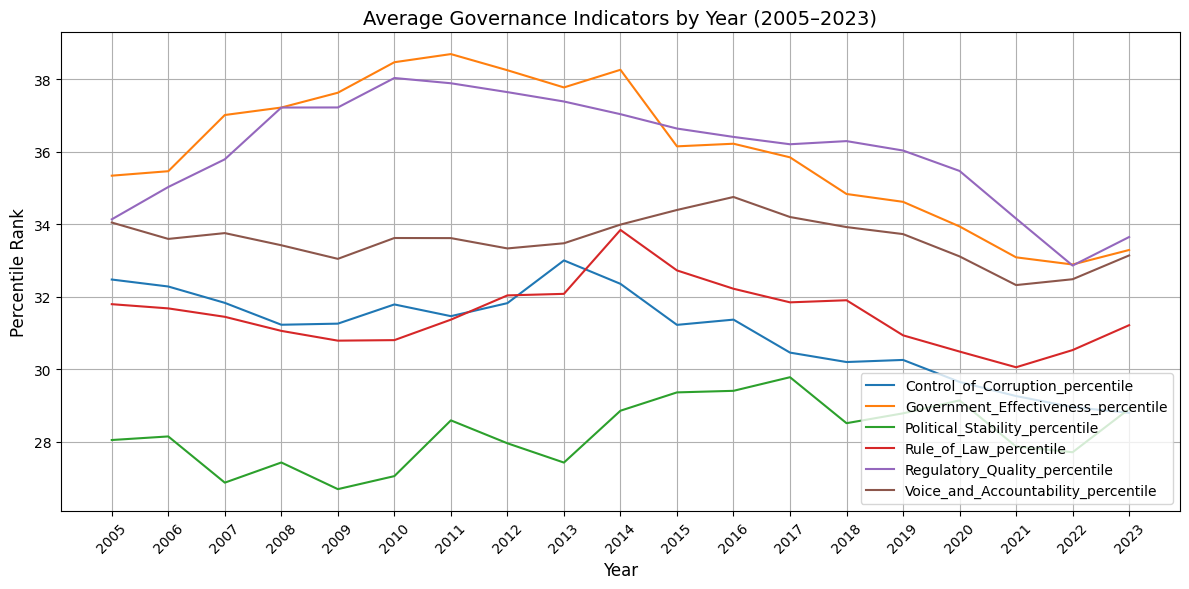

In [10]:
# Group by year and calculate the mean for each governance indicator
yearly_avg = wgi_data.groupby('year').mean(numeric_only=True)

# Plot all indicators on a single line graph
plt.figure(figsize=(12, 6))
for column in yearly_avg.columns:
    plt.plot(yearly_avg.index, yearly_avg[column], label=column)

# Customize the plot with x axis years at a 45-degree angle and all the axis label font size = 12 and the title font size = 14  
plt.title("Average Governance Indicators by Year (2005–2023)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.xticks(yearly_avg.index, rotation=45)
plt.ylabel("Percentile Rank", fontsize=12)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# Comprehensive Descriptive Statistics for Infrastructure Investment Analysis
# World Bank Indicators + PPI Database

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("="*100)
print("DESCRIPTIVE STATISTICS: WORLD BANK INDICATORS & PPI DATABASE")
print("="*100)

# ============================================================================
# PART 1: WORLD BANK DATA DESCRIPTIVES
# ============================================================================
print("\n" + "="*100)
print("PART 1: WORLD BANK INDICATORS (WDI + WGI)")
print("="*100)

print(f"\nDataset Overview:")
print(f"  - Total observations: {len(data):,}")
print(f"  - Countries: {data['country'].nunique()}")
print(f"  - Years: {data['year'].min()} - {data['year'].max()}")
print(f"  - Variables: {len(data.columns)}")

# 1.1 Define variable categories
governance_vars = [
    'Control_of_Corruption_percentile',
    'Government_Effectiveness_percentile', 
    'Political_Stability_percentile',
    'Rule_of_Law_percentile', 
    'Regulatory_Quality_percentile',
    'Voice_and_Accountability_percentile'
]

financial_vars = [
    'Domestic_credit_to_private_sector_pct_GDP',
    'Market_capitalization_pct_GDP',
    'Lending_interest_rate_pct',
    'Deposit_interest_rate_pct',
    'FDI_Inflows_pct_GDP',
    'FDI_net_inflows_current_USD',
    'Central_government_debt_pct_GDP',
    'Total_debt_service_pct_exports'
]

macro_vars = [
    'GDP_constant_2015_USD',
    'GDP_current_USD',
    'GDP_per_capita_constant_2015_USD',
    'GDP_growth_annual_pct',
    'Inflation_consumer_prices_annual_pct',
    'Current_account_balance_pct_GDP',
    'Exports_goods_services_pct_GDP',
    'Imports_goods_services_pct_GDP',
    'Trade_pct_GDP'
]

infrastructure_vars = [
    'Access_to_Electricity_pct',
    'Electric_power_transmission_losses_pct',
    'Electric_power_consumption_kWh_per_capita',
    'Mobile_cellular_subscriptions_per_100',
    'Fixed_broadband_subscriptions_per_100',
    'Individuals_using_Internet_pct'
]

fiscal_vars = [
    'Tax_revenue_pct_GDP',
    'Taxes_on_Income_Profits_CapitalGains_pct_revenue',
    'Government_expenditure_pct_GDP',
    'Gross_Capital_Formation_pct_GDP'
]

demographic_vars = [
    'Population_total',
    'Urban_population_pct_total',
    'Tertiary_education_enrollment_pct_gross',
    'Education_expenditure_pct_GDP',
    'GINI_Index'
]

# 1.2 Create summary statistics by category
print("\n" + "-"*100)
print("1.1 GOVERNANCE INDICATORS (WGI)")
print("-"*100)
wb_gov = data[governance_vars].describe().T
wb_gov['missing_pct'] = (data[governance_vars].isnull().sum() / len(data) * 100).round(2)
display(wb_gov[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing_pct']])

print("\n" + "-"*100)
print("1.2 FINANCIAL DEVELOPMENT INDICATORS")
print("-"*100)
wb_fin = data[financial_vars].describe().T
wb_fin['missing_pct'] = (data[financial_vars].isnull().sum() / len(data) * 100).round(2)
display(wb_fin[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing_pct']])

print("\n" + "-"*100)
print("1.3 MACROECONOMIC INDICATORS")
print("-"*100)
wb_macro = data[macro_vars].describe().T
wb_macro['missing_pct'] = (data[macro_vars].isnull().sum() / len(data) * 100).round(2)
display(wb_macro[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing_pct']])

print("\n" + "-"*100)
print("1.4 INFRASTRUCTURE INDICATORS")
print("-"*100)
wb_infra = data[infrastructure_vars].describe().T
wb_infra['missing_pct'] = (data[infrastructure_vars].isnull().sum() / len(data) * 100).round(2)
display(wb_infra[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing_pct']])

print("\n" + "-"*100)
print("1.5 FISCAL INDICATORS")
print("-"*100)
wb_fiscal = data[fiscal_vars].describe().T
wb_fiscal['missing_pct'] = (data[fiscal_vars].isnull().sum() / len(data) * 100).round(2)
display(wb_fiscal[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing_pct']])

print("\n" + "-"*100)
print("1.6 DEMOGRAPHIC & SOCIAL INDICATORS")
print("-"*100)
wb_demo = data[demographic_vars].describe().T
wb_demo['missing_pct'] = (data[demographic_vars].isnull().sum() / len(data) * 100).round(2)
display(wb_demo[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing_pct']])

# 1.3 Statistics by Tier
print("\n" + "-"*100)
print("1.7 KEY INDICATORS BY TIER (Mean Values)")
print("-"*100)

key_vars_by_tier = [
    'GDP_per_capita_constant_2015_USD',
    'GDP_growth_annual_pct',
    'FDI_Inflows_pct_GDP',
    'Regulatory_Quality_percentile',
    'Rule_of_Law_percentile',
    'Political_Stability_percentile',
    'Domestic_credit_to_private_sector_pct_GDP',
    'Access_to_Electricity_pct'
]

tier_summary = data.groupby('Tier')[key_vars_by_tier].mean().round(2)
display(tier_summary)

print("\nObservations per Tier:")
print(data.groupby('Tier').size())

# ============================================================================
# PART 2: PPI DATA DESCRIPTIVES
# ============================================================================
print("\n\n" + "="*100)
print("PART 2: PRIVATE PARTICIPATION IN INFRASTRUCTURE (PPI) DATABASE")
print("="*100)

print(f"\nDataset Overview:")
print(f"  - Total projects: {len(PPI):,}")
print(f"  - Countries: {PPI['country'].nunique()}")
print(f"  - Variables: {len(PPI.columns)}")

# 2.1 Identify numeric and categorical columns
numeric_PPI = PPI.select_dtypes(include=[np.number]).columns.tolist()
categorical_PPI = PPI.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"  - Numeric variables: {len(numeric_PPI)}")
print(f"  - Categorical variables: {len(categorical_PPI)}")

# 2.2 Key numeric variables
key_PPI_numeric = [
    'investment',
    'private',
    'fees',
    'physical',
    'debt',
    'equity',
    'capacity',
    'investment_real',
    'realphysicalassets',
    'realfeestogovernment'
]

# Filter to only existing columns
key_PPI_numeric = [col for col in key_PPI_numeric if col in PPI.columns]

if key_PPI_numeric:
    print("\n" + "-"*100)
    print("2.1 KEY FINANCIAL VARIABLES")
    print("-"*100)
    PPI_financial = PPI[key_PPI_numeric].describe().T
    PPI_financial['missing_pct'] = (PPI[key_PPI_numeric].isnull().sum() / len(PPI) * 100).round(2)
    display(PPI_financial[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing_pct']])

# 2.3 Projects by country
print("\n" + "-"*100)
print("2.2 TOP 15 COUNTRIES BY PROJECT COUNT")
print("-"*100)
country_counts = PPI['country'].value_counts().head(15)
print(country_counts)

# 2.4 Projects by sector
print("\n" + "-"*100)
print("2.3 PROJECTS BY SECTOR")
print("-"*100)
if 'sector' in PPI.columns:
    sector_counts = PPI['sector'].value_counts()
    print(sector_counts)
    print(f"\nTotal sectors: {PPI['sector'].nunique()}")

# 2.5 Projects by type
print("\n" + "-"*100)
print("2.4 PROJECTS BY TYPE")
print("-"*100)
if 'type' in PPI.columns:
    type_counts = PPI['type'].value_counts()
    print(type_counts)

# 2.6 Projects by status
print("\n" + "-"*100)
print("2.5 PROJECTS BY STATUS")
print("-"*100)
if 'status_n' in PPI.columns:
    status_counts = PPI['status_n'].value_counts()
    print(status_counts)

# 2.7 Investment statistics by sector
if 'sector' in PPI.columns and 'investment' in PPI.columns:
    print("\n" + "-"*100)
    print("2.6 INVESTMENT BY SECTOR (USD Millions)")
    print("-"*100)
    sector_investment = PPI.groupby('sector')['investment'].agg([
        ('Total_Investment', 'sum'),
        ('Avg_Investment', 'mean'),
        ('Median_Investment', 'median'),
        ('N_Projects', 'count')
    ]).sort_values('Total_Investment', ascending=False)
    display(sector_investment.round(2))

# 2.8 Investment statistics by year
if 'FundingYear' in PPI.columns and 'investment' in PPI.columns:
    print("\n" + "-"*100)
    print("2.7 INVESTMENT TRENDS OVER TIME")
    print("-"*100)
    year_investment = PPI.groupby('FundingYear')['investment'].agg([
        ('Total_Investment', 'sum'),
        ('Avg_Investment', 'mean'),
        ('N_Projects', 'count')
    ]).sort_index()
    
    print("\nFirst 5 years:")
    display(year_investment.head())
    print("\nLast 5 years:")
    display(year_investment.tail())
    
    print(f"\nYear range: {PPI['FundingYear'].min()} - {PPI['FundingYear'].max()}")

# 2.9 Blended finance indicators (for H2)
print("\n" + "-"*100)
print("2.8 BLENDED FINANCE / MDB PARTICIPATION (for Hypothesis 2)")
print("-"*100)

blended_finance_vars = ['MLS', 'BS', 'PPP', 'GGC']
available_bf = [var for var in blended_finance_vars if var in PPI.columns]

if available_bf:
    for var in available_bf:
        if PPI[var].dtype in ['object', 'category']:
            print(f"\n{var}:")
            print(PPI[var].value_counts())
        else:
            print(f"\n{var}: {PPI[var].sum()} projects ({(PPI[var].sum()/len(PPI)*100):.1f}%)")
else:
    print("No clear blended finance indicators found.")
    print("Check these variables: GGC, VDGS, TIGS, VIGS, MLS, BS, PPP")

# 2.10 Regional distribution
if 'Region' in PPI.columns:
    print("\n" + "-"*100)
    print("2.9 PROJECTS BY REGION")
    print("-"*100)
    region_stats = PPI.groupby('Region').agg({
        'ID': 'count',
        'investment': ['sum', 'mean']
    }).round(2)
    region_stats.columns = ['N_Projects', 'Total_Investment', 'Avg_Investment']
    display(region_stats.sort_values('Total_Investment', ascending=False))

# ============================================================================
# PART 3: COMBINED SUMMARY TABLE
# ============================================================================
print("\n\n" + "="*100)
print("PART 3: COMBINED SUMMARY FOR RESEARCH PAPER")
print("="*100)

# Create publication-ready table
all_vars = (governance_vars + financial_vars + macro_vars + 
            infrastructure_vars + fiscal_vars + demographic_vars)

summary_for_paper = pd.DataFrame({
    'Variable': all_vars,
    'N': [data[var].count() for var in all_vars],
    'Mean': [data[var].mean() for var in all_vars],
    'Std.Dev': [data[var].std() for var in all_vars],
    'Min': [data[var].min() for var in all_vars],
    'Max': [data[var].max() for var in all_vars]
}).round(2)

print("\nTable 1: Summary Statistics - World Bank Indicators")
print("-"*100)
display(summary_for_paper)

# PPI summary for paper
if 'investment' in PPI.columns:
    print("\nTable 2: Summary Statistics - PPI Database")
    print("-"*100)
    PPI_summary = pd.DataFrame({
        'Statistic': ['Total Projects', 'Total Investment (USD millions)', 
                     'Average Investment per Project', 'Median Investment per Project',
                     'Number of Countries', 'Number of Sectors',
                     'Year Range'],
        'Value': [
            f"{len(PPI):,}",
            f"{PPI['investment'].sum():,.2f}",
            f"{PPI['investment'].mean():,.2f}",
            f"{PPI['investment'].median():,.2f}",
            f"{PPI['country'].nunique()}",
            f"{PPI['sector'].nunique() if 'sector' in PPI.columns else 'N/A'}",
            f"{PPI['FundingYear'].min()}-{PPI['FundingYear'].max()}" if 'FundingYear' in PPI.columns else 'N/A'
        ]
    })
    display(PPI_summary)

# ============================================================================
# PART 4: EXPORT TABLES
# ============================================================================
print("\n" + "="*100)
print("EXPORTING SUMMARY TABLES")
print("="*100)

# Export to CSV
summary_for_paper.to_csv('table1_wb_descriptives.csv', index=False)
print("✓ Table 1 saved: table1_wb_descriptives.csv")

if 'investment' in PPI.columns:
    PPI_summary.to_csv('table2_PPI_descriptives.csv', index=False)
    print("✓ Table 2 saved: table2_PPI_descriptives.csv")

print("\n" + "="*100)
print("✓ DESCRIPTIVE STATISTICS COMPLETE!")
print("="*100)

DESCRIPTIVE STATISTICS: WORLD BANK INDICATORS & PPI DATABASE

PART 1: WORLD BANK INDICATORS (WDI + WGI)

Dataset Overview:
  - Total observations: 627
  - Countries: 33
  - Years: 2005 - 2023
  - Variables: 41

----------------------------------------------------------------------------------------------------
1.1 GOVERNANCE INDICATORS (WGI)
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max,missing_pct
Control_of_Corruption_percentile,627.0,31.038101,16.267361,0.476190,17.619047,31.904762,43.198595,69.756096,0.0
Government_Effectiveness_percentile,627.0,36.050194,18.003451,0.975610,20.863434,36.666668,50.000000,85.436890,0.0
Political_Stability_percentile,627.0,28.243239,18.083301,0.000000,11.820397,25.592417,44.339622,75.355453,0.0
Rule_of_Law_percentile,627.0,31.518603,16.773848,0.000000,18.571428,31.603773,45.454544,71.153847,0.0
Regulatory_Quality_percentile,627.0,36.056374,19.836490,0.000000,20.144001,36.320755,51.312370,76.442307,0.0
Voice_and_Accountability_percentile,627.0,33.576766,18.468273,0.480769,18.268229,33.816425,47.380417,71.497581,0.0



----------------------------------------------------------------------------------------------------
1.2 FINANCIAL DEVELOPMENT INDICATORS
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max,missing_pct
Domestic_credit_to_private_sector_pct_GDP,533.0,4.170528e+01,3.140450e+01,1.556177e+00,1.823519e+01,3.205313e+01,5.199878e+01,1.424220e+02,14.99
Market_capitalization_pct_GDP,304.0,5.523408e+01,7.763950e+01,5.062230e-02,1.644270e+01,2.893028e+01,5.318144e+01,5.872029e+02,51.52
Lending_interest_rate_pct,429.0,7.017243e+00,6.664071e+00,-1.320763e+01,3.171667e+00,6.219633e+00,8.961538e+00,5.431963e+01,31.58
Deposit_interest_rate_pct,486.0,7.797484e+00,7.370512e+00,1.330833e-02,3.444375e+00,6.477917e+00,1.025458e+01,9.499675e+01,22.49
FDI_Inflows_pct_GDP,615.0,3.413027e+00,4.633130e+00,-1.003838e+01,1.098107e+00,2.381069e+00,4.418613e+00,3.894287e+01,1.91
FDI_net_inflows_current_USD,625.0,3.388919e+09,4.816819e+09,-1.017640e+10,5.479612e+08,1.728248e+09,4.612249e+09,4.065879e+10,0.32
Central_government_debt_pct_GDP,171.0,5.169807e+01,1.904328e+01,1.073328e+01,3.850440e+01,5.133254e+01,6.523639e+01,1.035432e+02,72.73
Total_debt_service_pct_exports,558.0,1.695209e+01,1.519800e+01,1.578446e-01,6.122486e+00,1.266392e+01,2.400969e+01,1.066281e+02,11.00



----------------------------------------------------------------------------------------------------
1.3 MACROECONOMIC INDICATORS
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max,missing_pct
GDP_constant_2015_USD,608.0,1.543709e+11,1.900980e+11,4.237028e+09,2.720239e+10,7.011365e+10,2.167052e+11,1.255449e+12,3.03
GDP_current_USD,617.0,1.540338e+11,1.843744e+11,2.460247e+09,2.482734e+10,7.030720e+10,2.324687e+11,1.118253e+12,1.59
GDP_per_capita_constant_2015_USD,608.0,4.015420e+03,3.099945e+03,3.024750e+02,1.448193e+03,3.284687e+03,5.739491e+03,1.471357e+04,3.03
GDP_growth_annual_pct,618.0,4.266156e+00,4.079199e+00,-2.139990e+01,2.449119e+00,4.693503e+00,6.812758e+00,1.503000e+01,1.44
Inflation_consumer_prices_annual_pct,512.0,1.089900e+01,2.143012e+01,-3.749145e+00,3.243073e+00,6.403086e+00,1.030217e+01,2.549485e+02,18.34
Current_account_balance_pct_GDP,591.0,-2.945778e+00,8.430870e+00,-4.268363e+01,-6.143162e+00,-2.633615e+00,1.349648e+00,2.349854e+01,5.74
Exports_goods_services_pct_GDP,581.0,3.301723e+01,1.728102e+01,5.119171e+00,2.191899e+01,2.962897e+01,3.965865e+01,1.128990e+02,7.34
Imports_goods_services_pct_GDP,581.0,3.948781e+01,1.797218e+01,1.178057e+01,2.556872e+01,3.432424e+01,4.935885e+01,9.548518e+01,7.34
Trade_pct_GDP,581.0,7.250505e+01,3.257441e+01,2.059820e+01,4.844739e+01,6.610514e+01,8.629545e+01,2.038546e+02,7.34



----------------------------------------------------------------------------------------------------
1.4 INFRASTRUCTURE INDICATORS
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max,missing_pct
Access_to_Electricity_pct,627.0,82.215470,25.252599,11.800000,76.250000,96.700000,99.700000,100.0000,0.00
Electric_power_transmission_losses_pct,587.0,15.661330,9.284445,3.351877,9.752110,13.528258,18.475237,66.9745,6.38
Electric_power_consumption_kWh_per_capita,587.0,1604.840387,1399.921982,32.666615,504.708483,1132.358996,2386.346335,5560.9845,6.38
Mobile_cellular_subscriptions_per_100,621.0,89.716633,41.411737,0.271299,62.450200,95.157800,122.790000,183.2490,0.96
Fixed_broadband_subscriptions_per_100,600.0,5.330798,6.669231,0.000000,0.331259,2.645905,8.370995,37.0236,4.31
Individuals_using_Internet_pct,610.0,35.691004,26.597059,0.065239,12.042500,31.100000,57.043125,97.6927,2.71



----------------------------------------------------------------------------------------------------
1.5 FISCAL INDICATORS
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max,missing_pct
Tax_revenue_pct_GDP,466.0,14.562301,4.781304,0.914773,11.688278,14.130040,17.639659,26.682860,25.68
Taxes_on_Income_Profits_CapitalGains_pct_revenue,465.0,36.924165,14.795629,13.472974,25.247016,35.064104,45.082589,85.144038,25.84
Government_expenditure_pct_GDP,448.0,21.421290,7.668608,2.806068,15.287459,20.524459,26.822753,42.537652,28.55
Gross_Capital_Formation_pct_GDP,582.0,25.706604,8.335127,0.000000,19.994374,24.640037,30.999020,56.395811,7.18



----------------------------------------------------------------------------------------------------
1.6 DEMOGRAPHIC & SOCIAL INDICATORS
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max,missing_pct
Population_total,627.0,3.759720e+07,2.987101e+07,4.671102e+06,1.351452e+07,3.005821e+07,4.930879e+07,1.286917e+08,0.00
Urban_population_pct_total,627.0,5.473382e+01,2.125628e+01,1.514900e+01,3.621250e+01,5.730900e+01,7.196850e+01,9.246300e+01,0.00
Tertiary_education_enrollment_pct_gross,440.0,3.521769e+01,2.460559e+01,1.432030e+00,1.578461e+01,3.086654e+01,4.755024e+01,1.275780e+02,29.82
Education_expenditure_pct_GDP,474.0,4.106220e+00,1.343128e+00,3.130000e-03,3.297310e+00,4.047010e+00,4.895103e+00,9.124534e+00,24.40
GINI_Index,266.0,4.083120e+01,7.580633e+00,2.640000e+01,3.570000e+01,4.065000e+01,4.515000e+01,6.480000e+01,57.58



----------------------------------------------------------------------------------------------------
1.7 KEY INDICATORS BY TIER (Mean Values)
----------------------------------------------------------------------------------------------------


,GDP_per_capita_constant_2015_USD,GDP_growth_annual_pct,FDI_Inflows_pct_GDP,Regulatory_Quality_percentile,Rule_of_Law_percentile,Political_Stability_percentile,Domestic_credit_to_private_sector_pct_GDP,Access_to_Electricity_pct
Tier,,,,,,,,
Tier 1,4422.88,3.28,5.29,42.33,28.91,36.84,42.07,93.85
Tier 2,2949.20,4.63,3.90,36.60,34.07,32.43,38.74,66.07
Tier 3,4613.72,3.96,1.83,31.80,27.74,22.08,38.34,86.71
Tier 4,4174.03,5.45,2.54,33.16,36.40,19.04,52.37,86.88



Observations per Tier:
Tier
Tier 1    152
Tier 2    190
Tier 3    171
Tier 4    114
dtype: int64


PART 2: PRIVATE PARTICIPATION IN INFRASTRUCTURE (PPI) DATABASE

Dataset Overview:
  - Total projects: 11,167
  - Countries: 130
  - Variables: 58
  - Numeric variables: 27
  - Categorical variables: 31

----------------------------------------------------------------------------------------------------
2.1 KEY FINANCIAL VARIABLES
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max,missing_pct
investment,9782.0,221.945438,629.462905,0.030000,22.962500,70.000000,200.000000,35586.500000,12.40
private,10621.0,89.870037,20.196395,0.000000,93.000000,100.000000,100.000000,400.000000,4.89
fees,5843.0,60.365602,493.702582,0.000000,0.000000,0.000000,0.000000,29100.000000,47.68
physical,10446.0,173.825559,441.896107,0.000000,10.000000,50.090000,155.000000,14800.000000,6.46
debt,2184.0,226.825552,536.816304,0.000000,33.475000,80.000000,207.000000,13415.000000,80.44
investment_real,9782.0,305.994220,832.070260,0.046482,32.151704,94.368404,272.802673,43940.156250,12.40
realphysicalassets,10446.0,235.056129,584.637414,0.000000,14.786566,68.767513,209.723343,18865.015625,6.46
realfeestogovernment,5843.0,92.623498,666.335702,0.000000,0.000000,0.000000,0.000000,35931.000000,47.68



----------------------------------------------------------------------------------------------------
2.2 TOP 15 COUNTRIES BY PROJECT COUNT
----------------------------------------------------------------------------------------------------
country
China                 2075
Brazil                2049
India                 1281
Argentina              601
Russian Federation     472
Mexico                 410
Colombia               290
Turkiye                283
Peru                   245
Philippines            232
Thailand               213
Indonesia              179
Vietnam                170
Malaysia               165
South Africa           140
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------
2.3 PROJECTS BY SECTOR
----------------------------------------------------------------------------------------------------
sector
Energy                   6287
Transport                2586
Water and sewerage       12

,Total_Investment,Avg_Investment,Median_Investment,N_Projects
sector,,,,
Energy,1112288.46,200.30,68.37,5553
Transport,790668.41,335.03,128.06,2360
ICT,123653.87,295.12,49.00,419
Water and sewerage,104962.47,102.20,25.00,1027
Municipal Solid Waste,39497.05,93.37,41.60,423



----------------------------------------------------------------------------------------------------
2.7 INVESTMENT TRENDS OVER TIME
----------------------------------------------------------------------------------------------------

First 5 years:


,Total_Investment,Avg_Investment,N_Projects
FundingYear,,,
1992.0,2.6,2.6,1
1995.0,1400.0,1400.0,1
1996.0,225.0,225.0,1
1997.0,354.0,177.0,2
2000.0,710.0,710.0,1



Last 5 years:


,Total_Investment,Avg_Investment,N_Projects
FundingYear,,,
2019.0,58595.95,318.456250,184
2020.0,36418.08,303.484000,120
2021.0,25503.32,293.141609,87
2022.0,47953.99,317.576093,151
2023.0,16589.11,164.248614,101



Year range: 1992.0 - 2023.0

----------------------------------------------------------------------------------------------------
2.8 BLENDED FINANCE / MDB PARTICIPATION (for Hypothesis 2)
----------------------------------------------------------------------------------------------------

MLS:
MLS
Without MLS    9413
With MLS       1754
Name: count, dtype: int64

BS:
BS
Without BLS    10742
With BLS         425
Name: count, dtype: int64

PPP:
PPP
PPP Project    9462
Other PPI      1705
Name: count, dtype: int64

GGC:
GGC
Federal             5132
NA                  2821
Local               1975
State/Provincial    1239
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------
2.9 PROJECTS BY REGION
----------------------------------------------------------------------------------------------------


,N_Projects,Total_Investment,Avg_Investment
Region,,,
LAC,4048,758657.43,213.35
EAP,3160,603695.95,206.82
SAR,1643,350344.03,223.29
ECA,1337,288178.51,314.26
AFR,724,99306.59,167.18
MENA,255,70887.75,312.28




PART 3: COMBINED SUMMARY FOR RESEARCH PAPER

Table 1: Summary Statistics - World Bank Indicators
----------------------------------------------------------------------------------------------------


,Variable,N,Mean,Std.Dev,Min,Max
0,Control_of_Corruption_percentile,627,3.104000e+01,1.627000e+01,4.800000e-01,6.976000e+01
1,Government_Effectiveness_percentile,627,3.605000e+01,1.800000e+01,9.800000e-01,8.544000e+01
2,Political_Stability_percentile,627,2.824000e+01,1.808000e+01,0.000000e+00,7.536000e+01
3,Rule_of_Law_percentile,627,3.152000e+01,1.677000e+01,0.000000e+00,7.115000e+01
4,Regulatory_Quality_percentile,627,3.606000e+01,1.984000e+01,0.000000e+00,7.644000e+01
5,Voice_and_Accountability_percentile,627,3.358000e+01,1.847000e+01,4.800000e-01,7.150000e+01
6,Domestic_credit_to_private_sector_pct_GDP,533,4.171000e+01,3.140000e+01,1.560000e+00,1.424200e+02
7,Market_capitalization_pct_GDP,304,5.523000e+01,7.764000e+01,5.000000e-02,5.872000e+02
8,Lending_interest_rate_pct,429,7.020000e+00,6.660000e+00,-1.321000e+01,5.432000e+01
9,Deposit_interest_rate_pct,486,7.800000e+00,7.370000e+00,1.000000e-02,9.500000e+01



Table 2: Summary Statistics - PPI Database
----------------------------------------------------------------------------------------------------


,Statistic,Value
0,Total Projects,"11,167"
1,Total Investment (USD millions),"2,171,070.27"
2,Average Investment per Project,221.95
3,Median Investment per Project,70.00
4,Number of Countries,130
5,Number of Sectors,5
6,Year Range,1992.0-2023.0



EXPORTING SUMMARY TABLES
✓ Table 1 saved: table1_wb_descriptives.csv
✓ Table 2 saved: table2_PPI_descriptives.csv

✓ DESCRIPTIVE STATISTICS COMPLETE!


In [12]:
# Map PPI country names to World Bank ISO3 codes and filter by country AND year

import pandas as pd
import numpy as np

print("="*80)
print("FILTERING PPI DATA: COUNTRIES + YEARS (2005-2023)")
print("="*80)

# Your tier countries with ISO3 codes
all_countries = {
    "Paraguay": "PRY",
    "El Salvador": "SLV",
    "Nicaragua": "NIC",
    "Serbia": "SRB",
    "Bulgaria": "BGR",
    "Lao PDR": "LAO",
    "Lebanon": "LBN",
    "Kyrgyz Republic": "KGZ",
    "Peru": "PER",
    "Malaysia": "MYS",
    "Ghana": "GHA",
    "Mozambique": "MOZ",
    "Angola": "AGO",
    "Nepal": "NPL",
    "Venezuela, RB": "VEN",
    "Zambia": "ZMB",
    "Sri Lanka": "LKA",
    "Mali": "MLI",
    "Argentina": "ARG",
    "Algeria": "DZA",
    "Iraq": "IRQ",
    "Morocco": "MAR",
    "Kenya": "KEN",
    "South Africa": "ZAF",
    "Myanmar": "MMR",
    "Colombia": "COL",
    "Uzbekistan": "UZB",
    "Egypt, Arab Rep.": "EGY",
    "Ethiopia": "ETH",
    "Philippines": "PHL",
    "Vietnam": "VNM",
    "Iran, Islamic Rep.": "IRN",
    "Turkey": "TUR"
}

# Special case: PPI uses "Turkiye" but WB uses "Turkey"
name_mapping = {
    "Turkiye": "Turkey"
}

print(f"\nOriginal PPI data: {len(PPI):,} projects")

# STEP 1: Clean country names
print("\n" + "="*80)
print("STEP 1: MAPPING COUNTRY NAMES")
print("="*80)

PPI['country_clean'] = PPI['country'].replace(name_mapping)
target_country_names = list(all_countries.keys())

# Filter by country
PPI_country_filtered = PPI[PPI['country_clean'].isin(target_country_names)].copy()
print(f"After country filter: {len(PPI_country_filtered):,} projects")
print(f"Projects removed: {len(PPI) - len(PPI_country_filtered):,}")

# STEP 2: Filter by year
print("\n" + "="*80)
print("STEP 2: FILTERING BY YEAR (2005-2023)")
print("="*80)

# Identify the year column
year_col = None
for col in ['FundingYear', 'year', 'Year', 'closingyear', 'financial_closure_year']:
    if col in PPI_country_filtered.columns:
        year_col = col
        print(f"Using '{year_col}' as the year variable")
        break

if year_col is None:
    print("⚠️  Warning: No year column found!")
    print(f"Available columns: {PPI_country_filtered.columns.tolist()}")
    PPI_filtered = PPI_country_filtered
else:
    # Check year range before filtering
    print(f"\nYear range in data (before filter): {PPI_country_filtered[year_col].min()} - {PPI_country_filtered[year_col].max()}")
    
    # Filter by year: 2005-2023
    PPI_filtered = PPI_country_filtered[
        (PPI_country_filtered[year_col] >= 2005) & 
        (PPI_country_filtered[year_col] <= 2023)
    ].copy()
    
    print(f"After year filter (2005-2023): {len(PPI_filtered):,} projects")
    print(f"Projects removed by year filter: {len(PPI_country_filtered) - len(PPI_filtered):,}")
    
    # Show year distribution
    print(f"\nYear range in filtered data: {PPI_filtered[year_col].min()} - {PPI_filtered[year_col].max()}")

# STEP 3: Add ISO3 codes and Tier
print("\n" + "="*80)
print("STEP 3: ADDING ISO3 CODES AND TIER CLASSIFICATION")
print("="*80)

# Add ISO3 code
country_to_iso = all_countries
PPI_filtered['country_code'] = PPI_filtered['country_clean'].map(country_to_iso)

# Add Tier
tier_mapping = {
    "Paraguay": "Tier 1", "El Salvador": "Tier 1", "Nicaragua": "Tier 1", 
    "Serbia": "Tier 1", "Bulgaria": "Tier 1", "Lao PDR": "Tier 1", 
    "Lebanon": "Tier 1", "Kyrgyz Republic": "Tier 1",
    
    "Peru": "Tier 2", "Malaysia": "Tier 2", "Ghana": "Tier 2", 
    "Mozambique": "Tier 2", "Angola": "Tier 2", "Nepal": "Tier 2", 
    "Venezuela, RB": "Tier 2", "Zambia": "Tier 2", "Sri Lanka": "Tier 2", 
    "Mali": "Tier 2",
    
    "Argentina": "Tier 3", "Algeria": "Tier 3", "Iraq": "Tier 3", 
    "Morocco": "Tier 3", "Kenya": "Tier 3", "South Africa": "Tier 3", 
    "Myanmar": "Tier 3", "Colombia": "Tier 3", "Uzbekistan": "Tier 3",
    
    "Egypt, Arab Rep.": "Tier 4", "Ethiopia": "Tier 4", "Philippines": "Tier 4", 
    "Vietnam": "Tier 4", "Iran, Islamic Rep.": "Tier 4", "Turkey": "Tier 4"
}

PPI_filtered['Tier'] = PPI_filtered['country_clean'].map(tier_mapping)

# Rename year column to 'year' for consistency
if year_col and year_col != 'year':
    PPI_filtered['year'] = PPI_filtered[year_col]

print("✓ Added columns: country_code, Tier, year")

# SUMMARY STATISTICS
print("\n" + "="*80)
print("FILTERING SUMMARY")
print("="*80)
print(f"Original PPI data:        {len(PPI):,} projects")
print(f"After country filter:     {len(PPI_country_filtered):,} projects ({len(PPI_country_filtered)/len(PPI)*100:.1f}%)")
print(f"After year filter:        {len(PPI_filtered):,} projects ({len(PPI_filtered)/len(PPI)*100:.1f}%)")
print(f"Total projects removed:   {len(PPI) - len(PPI_filtered):,}")
print(f"\nCountries in final data:  {PPI_filtered['country_code'].nunique()}")
if 'year' in PPI_filtered.columns:
    print(f"Year range:               {PPI_filtered['year'].min()} - {PPI_filtered['year'].max()}")

# MATCHED COUNTRIES
print("\n" + "="*80)
print("PROJECTS PER COUNTRY (2005-2023)")
print("="*80)

country_summary = PPI_filtered.groupby(['country_clean', 'country_code', 'Tier']).size().reset_index(name='N_Projects')
country_summary = country_summary.sort_values('N_Projects', ascending=False)

print("\nTop 20 countries by project count:")
display(country_summary.head(20))

print(f"\nTotal countries with projects: {len(country_summary)}")

# Check which target countries have NO projects in the filtered data
matched_countries = set(PPI_filtered['country_clean'].unique())
missing_countries = set(target_country_names) - matched_countries
if missing_countries:
    print("\n" + "="*80)
    print("⚠️  COUNTRIES WITH NO PROJECTS (2005-2023)")
    print("="*80)
    print(f"{len(missing_countries)} countries have no projects in 2005-2023:")
    for country in sorted(missing_countries):
        iso_code = country_to_iso.get(country, 'N/A')
        print(f"  {country:30s} ({iso_code})")

# STATISTICS BY TIER
print("\n" + "="*80)
print("PROJECTS BY TIER (2005-2023)")
print("="*80)

if 'investment' in PPI_filtered.columns:
    tier_stats = PPI_filtered.groupby('Tier').agg({
        'ID': 'count',
        'investment': ['sum', 'mean', 'median']
    }).round(2)
    tier_stats.columns = ['N_Projects', 'Total_Investment', 'Avg_Investment', 'Median_Investment']
else:
    tier_stats = PPI_filtered.groupby('Tier').size().to_frame(name='N_Projects')

display(tier_stats)

# STATISTICS BY SECTOR
if 'sector' in PPI_filtered.columns:
    print("\n" + "="*80)
    print("PROJECTS BY SECTOR (2005-2023)")
    print("="*80)
    sector_counts = PPI_filtered['sector'].value_counts()
    print(sector_counts)

# INVESTMENT STATISTICS
if 'investment' in PPI_filtered.columns:
    print("\n" + "="*80)
    print("INVESTMENT STATISTICS (2005-2023, USD Millions)")
    print("="*80)
    print(f"Total Investment:   ${PPI_filtered['investment'].sum():,.2f}")
    print(f"Mean Investment:    ${PPI_filtered['investment'].mean():,.2f}")
    print(f"Median Investment:  ${PPI_filtered['investment'].median():,.2f}")
    print(f"Min Investment:     ${PPI_filtered['investment'].min():,.2f}")
    print(f"Max Investment:     ${PPI_filtered['investment'].max():,.2f}")
    
    # Investment by year
    if 'year' in PPI_filtered.columns:
        print("\n" + "="*80)
        print("INVESTMENT BY YEAR")
        print("="*80)
        year_investment = PPI_filtered.groupby('year')['investment'].agg([
            ('Total', 'sum'),
            ('Mean', 'mean'),
            ('N_Projects', 'count')
        ]).round(2)
        
        print("\nFirst 5 years:")
        display(year_investment.head())
        print("\nLast 5 years:")
        display(year_investment.tail())

# BLENDED FINANCE INDICATORS (for H2)
print("\n" + "="*80)
print("BLENDED FINANCE INDICATORS (for Hypothesis 2)")
print("="*80)

blended_finance_vars = ['MLS', 'BS', 'PPP', 'GGC', 'VDGS', 'TIGS', 'VIGS']
available_bf = [var for var in blended_finance_vars if var in PPI_filtered.columns]

if available_bf:
    print(f"\nFound {len(available_bf)} blended finance indicators:")
    for var in available_bf:
        if PPI_filtered[var].dtype in ['object', 'category', bool]:
            non_null = PPI_filtered[var].notna().sum()
            print(f"  {var}: {non_null} projects ({non_null/len(PPI_filtered)*100:.1f}%)")
        else:
            positive = (PPI_filtered[var] > 0).sum()
            print(f"  {var}: {positive} projects ({positive/len(PPI_filtered)*100:.1f}%)")
else:
    print("No standard blended finance indicators found.")
    print("Available columns to check:", [col for col in PPI_filtered.columns if col not in ['ID', 'country', 'year']])

print("\n" + "="*80)
print("✓ FILTERED PPI DATA IS READY!")
print("="*80)
print("\nFiltered dataset: PPI_filtered")
print("Key columns:")
print("  - country_code: ISO3 code (use to merge with World Bank data)")
print("  - country_clean: Full country name")
print("  - year: Year of project (2005-2023)")
print("  - Tier: Country tier classification")
print("\nMerge command:")
print("  merged = pd.merge(data, PPI_filtered, ")
print("                    left_on=['country', 'year'], ")
print("                    right_on=['country_code', 'year'], ")
print("                    how='left')")

# SAMPLE OUTPUT
print("\n" + "="*80)
print("SAMPLE OF FILTERED DATA")
print("="*80)
sample_cols = ['country_clean', 'country_code', 'year', 'Tier', 'sector', 'investment']
available_cols = [col for col in sample_cols if col in PPI_filtered.columns]
display(PPI_filtered[available_cols].head(15))

FILTERING PPI DATA: COUNTRIES + YEARS (2005-2023)

Original PPI data: 11,167 projects

STEP 1: MAPPING COUNTRY NAMES
After country filter: 2,882 projects
Projects removed: 8,285

STEP 2: FILTERING BY YEAR (2005-2023)
Using 'FundingYear' as the year variable

Year range in data (before filter): 1995.0 - 2023.0
After year filter (2005-2023): 738 projects
Projects removed by year filter: 2,144

Year range in filtered data: 2005.0 - 2023.0

STEP 3: ADDING ISO3 CODES AND TIER CLASSIFICATION
✓ Added columns: country_code, Tier, year

FILTERING SUMMARY
Original PPI data:        11,167 projects
After country filter:     2,882 projects (25.8%)
After year filter:        738 projects (6.6%)
Total projects removed:   10,429

Countries in final data:  31
Year range:               2005.0 - 2023.0

PROJECTS PER COUNTRY (2005-2023)



Top 20 countries by project count:


,country_clean,country_code,Tier,N_Projects
14491,Turkey,TUR,Tier 4,130
12518,South Africa,ZAF,Tier 3,94
11121,Peru,PER,Tier 2,68
15367,Vietnam,VNM,Tier 4,57
11251,Philippines,PHL,Tier 4,56
502,Argentina,ARG,Tier 3,47
3114,Colombia,COL,Tier 3,42
4487,"Egypt, Arab Rep.",EGY,Tier 4,36
12577,Sri Lanka,LKA,Tier 2,22
8753,Malaysia,MYS,Tier 2,20



Total countries with projects: 16120

⚠️  COUNTRIES WITH NO PROJECTS (2005-2023)
2 countries have no projects in 2005-2023:
  Kyrgyz Republic                (KGZ)
  Venezuela, RB                  (VEN)

PROJECTS BY TIER (2005-2023)


,N_Projects,Total_Investment,Avg_Investment,Median_Investment
Tier,,,,
Tier 1,58,25063.14,432.12,143.32
Tier 2,158,47648.84,305.44,105.90
Tier 3,238,66250.27,280.72,173.71
Tier 4,284,156221.39,555.95,115.00



PROJECTS BY SECTOR (2005-2023)
sector
Energy                   581
Transport                117
ICT                       18
Water and sewerage        13
Municipal Solid Waste      9
Name: count, dtype: int64

INVESTMENT STATISTICS (2005-2023, USD Millions)
Total Investment:   $295,183.64
Mean Investment:    $403.81
Median Investment:  $138.00
Min Investment:     $2.00
Max Investment:     $35,586.50

INVESTMENT BY YEAR

First 5 years:


,Total,Mean,N_Projects
year,,,
2005.0,1786.10,446.52,4
2007.0,191.20,95.60,2
2008.0,326.65,40.83,8
2009.0,794.30,132.38,6
2010.0,11697.98,316.16,37



Last 5 years:


,Total,Mean,N_Projects
year,,,
2019.0,17635.19,352.70,50
2020.0,9110.56,350.41,26
2021.0,10456.14,435.67,24
2022.0,17908.46,319.79,56
2023.0,9417.47,209.28,45



BLENDED FINANCE INDICATORS (for Hypothesis 2)

Found 7 blended finance indicators:
  MLS: 738 projects (100.0%)
  BS: 738 projects (100.0%)
  PPP: 738 projects (100.0%)
  GGC: 738 projects (100.0%)
  VDGS: 14 projects (1.9%)
  TIGS: 738 projects (100.0%)
  VIGS: 2 projects (0.3%)

✓ FILTERED PPI DATA IS READY!

Filtered dataset: PPI_filtered
Key columns:
  - country_code: ISO3 code (use to merge with World Bank data)
  - country_clean: Full country name
  - year: Year of project (2005-2023)
  - Tier: Country tier classification

Merge command:
  merged = pd.merge(data, PPI_filtered, 
                    left_on=['country', 'year'], 
                    right_on=['country_code', 'year'], 
                    how='left')

SAMPLE OF FILTERED DATA


,country_clean,country_code,year,Tier,sector,investment
3790,Vietnam,VNM,2005.0,Tier 4,Energy,11.60
3809,Malaysia,MYS,2005.0,Tier 2,Transport,368.00
3952,Bulgaria,BGR,2005.0,Tier 1,Energy,1400.00
4078,Nepal,NPL,2005.0,Tier 2,Energy,6.50
4544,"Iran, Islamic Rep.",IRN,2007.0,Tier 4,Energy,158.20
4792,Vietnam,VNM,2007.0,Tier 4,Energy,33.00
5044,Turkey,TUR,2008.0,Tier 4,Energy,162.00
5144,Sri Lanka,LKA,2008.0,Tier 2,Energy,6.50
5198,Sri Lanka,LKA,2008.0,Tier 2,Energy,3.80
5211,Sri Lanka,LKA,2008.0,Tier 2,Energy,6.95


In [13]:
# Comprehensive Descriptive Statistics for Infrastructure Investment Analysis
# World Bank Indicators + PPI_filtered Database

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("="*100)
print("DESCRIPTIVE STATISTICS: WORLD BANK INDICATORS & PPI_filtered DATABASE")
print("="*100)

# ============================================================================
# PART 1: WORLD BANK DATA DESCRIPTIVES
# ============================================================================
print("\n" + "="*100)
print("PART 1: WORLD BANK INDICATORS (WDI + WGI)")
print("="*100)

print(f"\nDataset Overview:")
print(f"  - Total observations: {len(data):,}")
print(f"  - Countries: {data['country'].nunique()}")
print(f"  - Years: {data['year'].min()} - {data['year'].max()}")
print(f"  - Variables: {len(data.columns)}")

# 1.1 Define variable categories
governance_vars = [
    'Control_of_Corruption_percentile',
    'Government_Effectiveness_percentile', 
    'Political_Stability_percentile',
    'Rule_of_Law_percentile', 
    'Regulatory_Quality_percentile',
    'Voice_and_Accountability_percentile'
]

financial_vars = [
    'Domestic_credit_to_private_sector_pct_GDP',
    'Market_capitalization_pct_GDP',
    'Lending_interest_rate_pct',
    'Deposit_interest_rate_pct',
    'FDI_Inflows_pct_GDP',
    'FDI_net_inflows_current_USD',
    'Central_government_debt_pct_GDP',
    'Total_debt_service_pct_exports'
]

macro_vars = [
    'GDP_constant_2015_USD',
    'GDP_current_USD',
    'GDP_per_capita_constant_2015_USD',
    'GDP_growth_annual_pct',
    'Inflation_consumer_prices_annual_pct',
    'Current_account_balance_pct_GDP',
    'Exports_goods_services_pct_GDP',
    'Imports_goods_services_pct_GDP',
    'Trade_pct_GDP'
]

infrastructure_vars = [
    'Access_to_Electricity_pct',
    'Electric_power_transmission_losses_pct',
    'Electric_power_consumption_kWh_per_capita',
    'Mobile_cellular_subscriptions_per_100',
    'Fixed_broadband_subscriptions_per_100',
    'Individuals_using_Internet_pct'
]

fiscal_vars = [
    'Tax_revenue_pct_GDP',
    'Taxes_on_Income_Profits_CapitalGains_pct_revenue',
    'Government_expenditure_pct_GDP',
    'Gross_Capital_Formation_pct_GDP'
]

demographic_vars = [
    'Population_total',
    'Urban_population_pct_total',
    'Tertiary_education_enrollment_pct_gross',
    'Education_expenditure_pct_GDP',
    'GINI_Index'
]

# 1.2 Create summary statistics by category
print("\n" + "-"*100)
print("1.1 GOVERNANCE INDICATORS (WGI)")
print("-"*100)
wb_gov = data[governance_vars].describe().T
wb_gov['missing_pct'] = (data[governance_vars].isnull().sum() / len(data) * 100).round(2)
display(wb_gov[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing_pct']])

print("\n" + "-"*100)
print("1.2 FINANCIAL DEVELOPMENT INDICATORS")
print("-"*100)
wb_fin = data[financial_vars].describe().T
wb_fin['missing_pct'] = (data[financial_vars].isnull().sum() / len(data) * 100).round(2)
display(wb_fin[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing_pct']])

print("\n" + "-"*100)
print("1.3 MACROECONOMIC INDICATORS")
print("-"*100)
wb_macro = data[macro_vars].describe().T
wb_macro['missing_pct'] = (data[macro_vars].isnull().sum() / len(data) * 100).round(2)
display(wb_macro[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing_pct']])

print("\n" + "-"*100)
print("1.4 INFRASTRUCTURE INDICATORS")
print("-"*100)
wb_infra = data[infrastructure_vars].describe().T
wb_infra['missing_pct'] = (data[infrastructure_vars].isnull().sum() / len(data) * 100).round(2)
display(wb_infra[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing_pct']])

print("\n" + "-"*100)
print("1.5 FISCAL INDICATORS")
print("-"*100)
wb_fiscal = data[fiscal_vars].describe().T
wb_fiscal['missing_pct'] = (data[fiscal_vars].isnull().sum() / len(data) * 100).round(2)
display(wb_fiscal[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing_pct']])

print("\n" + "-"*100)
print("1.6 DEMOGRAPHIC & SOCIAL INDICATORS")
print("-"*100)
wb_demo = data[demographic_vars].describe().T
wb_demo['missing_pct'] = (data[demographic_vars].isnull().sum() / len(data) * 100).round(2)
display(wb_demo[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing_pct']])

# 1.3 Statistics by Tier
print("\n" + "-"*100)
print("1.7 KEY INDICATORS BY TIER (Mean Values)")
print("-"*100)

key_vars_by_tier = [
    'GDP_per_capita_constant_2015_USD',
    'GDP_growth_annual_pct',
    'FDI_Inflows_pct_GDP',
    'Regulatory_Quality_percentile',
    'Rule_of_Law_percentile',
    'Political_Stability_percentile',
    'Domestic_credit_to_private_sector_pct_GDP',
    'Access_to_Electricity_pct'
]

tier_summary = data.groupby('Tier')[key_vars_by_tier].mean().round(2)
display(tier_summary)

print("\nObservations per Tier:")
print(data.groupby('Tier').size())

# ============================================================================
# PART 2: PPI_filtered DATA DESCRIPTIVES
# ============================================================================
print("\n\n" + "="*100)
print("PART 2: PRIVATE PARTICIPATION IN INFRASTRUCTURE (PPI_filtered) DATABASE")
print("="*100)

print(f"\nDataset Overview:")
print(f"  - Total projects: {len(PPI_filtered):,}")
print(f"  - Countries: {PPI_filtered['country'].nunique()}")
print(f"  - Variables: {len(PPI_filtered.columns)}")

# 2.1 Identify numeric and categorical columns
numeric_PPI_filtered = PPI_filtered.select_dtypes(include=[np.number]).columns.tolist()
categorical_PPI_filtered = PPI_filtered.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"  - Numeric variables: {len(numeric_PPI_filtered)}")
print(f"  - Categorical variables: {len(categorical_PPI_filtered)}")

# 2.2 Key numeric variables
key_PPI_filtered_numeric = [
    'investment',
    'private',
    'fees',
    'physical',
    'debt',
    'equity',
    'capacity',
    'investment_real',
    'realphysicalassets',
    'realfeestogovernment'
]

# Filter to only existing columns
key_PPI_filtered_numeric = [col for col in key_PPI_filtered_numeric if col in PPI_filtered.columns]

if key_PPI_filtered_numeric:
    print("\n" + "-"*100)
    print("2.1 KEY FINANCIAL VARIABLES")
    print("-"*100)
    PPI_filtered_financial = PPI_filtered[key_PPI_filtered_numeric].describe().T
    PPI_filtered_financial['missing_pct'] = (PPI_filtered[key_PPI_filtered_numeric].isnull().sum() / len(PPI_filtered) * 100).round(2)
    display(PPI_filtered_financial[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing_pct']])

# 2.3 Projects by country
print("\n" + "-"*100)
print("2.2 TOP 15 COUNTRIES BY PROJECT COUNT")
print("-"*100)
country_counts = PPI_filtered['country'].value_counts().head(15)
print(country_counts)

# 2.4 Projects by sector
print("\n" + "-"*100)
print("2.3 PROJECTS BY SECTOR")
print("-"*100)
if 'sector' in PPI_filtered.columns:
    sector_counts = PPI_filtered['sector'].value_counts()
    print(sector_counts)
    print(f"\nTotal sectors: {PPI_filtered['sector'].nunique()}")

# 2.5 Projects by type
print("\n" + "-"*100)
print("2.4 PROJECTS BY TYPE")
print("-"*100)
if 'type' in PPI_filtered.columns:
    type_counts = PPI_filtered['type'].value_counts()
    print(type_counts)

# 2.6 Projects by status
print("\n" + "-"*100)
print("2.5 PROJECTS BY STATUS")
print("-"*100)
if 'status_n' in PPI_filtered.columns:
    status_counts = PPI_filtered['status_n'].value_counts()
    print(status_counts)

# 2.7 Investment statistics by sector
if 'sector' in PPI_filtered.columns and 'investment' in PPI_filtered.columns:
    print("\n" + "-"*100)
    print("2.6 INVESTMENT BY SECTOR (USD Millions)")
    print("-"*100)
    sector_investment = PPI_filtered.groupby('sector')['investment'].agg([
        ('Total_Investment', 'sum'),
        ('Avg_Investment', 'mean'),
        ('Median_Investment', 'median'),
        ('N_Projects', 'count')
    ]).sort_values('Total_Investment', ascending=False)
    display(sector_investment.round(2))

# 2.8 Investment statistics by year
if 'FundingYear' in PPI_filtered.columns and 'investment' in PPI_filtered.columns:
    print("\n" + "-"*100)
    print("2.7 INVESTMENT TRENDS OVER TIME")
    print("-"*100)
    year_investment = PPI_filtered.groupby('FundingYear')['investment'].agg([
        ('Total_Investment', 'sum'),
        ('Avg_Investment', 'mean'),
        ('N_Projects', 'count')
    ]).sort_index()
    
    print("\nFirst 5 years:")
    display(year_investment.head())
    print("\nLast 5 years:")
    display(year_investment.tail())
    
    print(f"\nYear range: {PPI_filtered['FundingYear'].min()} - {PPI_filtered['FundingYear'].max()}")

# 2.9 Blended finance indicators (for H2)
print("\n" + "-"*100)
print("2.8 BLENDED FINANCE / MDB PARTICIPATION (for Hypothesis 2)")
print("-"*100)

blended_finance_vars = ['MLS', 'BS', 'PPP', 'GGC']
available_bf = [var for var in blended_finance_vars if var in PPI_filtered.columns]

if available_bf:
    for var in available_bf:
        if PPI_filtered[var].dtype in ['object', 'category']:
            print(f"\n{var}:")
            print(PPI_filtered[var].value_counts())
        else:
            print(f"\n{var}: {PPI_filtered[var].sum()} projects ({(PPI_filtered[var].sum()/len(PPI_filtered)*100):.1f}%)")
else:
    print("No clear blended finance indicators found.")
    print("Check these variables: GGC, VDGS, TIGS, VIGS, MLS, BS, PPP")

# 2.10 Regional distribution
if 'Region' in PPI_filtered.columns:
    print("\n" + "-"*100)
    print("2.9 PROJECTS BY REGION")
    print("-"*100)
    region_stats = PPI_filtered.groupby('Region').agg({
        'ID': 'count',
        'investment': ['sum', 'mean']
    }).round(2)
    region_stats.columns = ['N_Projects', 'Total_Investment', 'Avg_Investment']
    display(region_stats.sort_values('Total_Investment', ascending=False))

# ============================================================================
# PART 3: COMBINED SUMMARY TABLE
# ============================================================================
print("\n\n" + "="*100)
print("PART 3: COMBINED SUMMARY FOR RESEARCH PAPER")
print("="*100)

# Create publication-ready table
all_vars = (governance_vars + financial_vars + macro_vars + 
            infrastructure_vars + fiscal_vars + demographic_vars)

summary_for_paper = pd.DataFrame({
    'Variable': all_vars,
    'N': [data[var].count() for var in all_vars],
    'Mean': [data[var].mean() for var in all_vars],
    'Std.Dev': [data[var].std() for var in all_vars],
    'Min': [data[var].min() for var in all_vars],
    'Max': [data[var].max() for var in all_vars]
}).round(2)

print("\nTable 1: Summary Statistics - World Bank Indicators")
print("-"*100)
display(summary_for_paper)

# PPI_filtered summary for paper
if 'investment' in PPI_filtered.columns:
    print("\nTable 2: Summary Statistics - PPI_filtered Database")
    print("-"*100)
    PPI_filtered_summary = pd.DataFrame({
        'Statistic': ['Total Projects', 'Total Investment (USD millions)', 
                     'Average Investment per Project', 'Median Investment per Project',
                     'Number of Countries', 'Number of Sectors',
                     'Year Range'],
        'Value': [
            f"{len(PPI_filtered):,}",
            f"{PPI_filtered['investment'].sum():,.2f}",
            f"{PPI_filtered['investment'].mean():,.2f}",
            f"{PPI_filtered['investment'].median():,.2f}",
            f"{PPI_filtered['country'].nunique()}",
            f"{PPI_filtered['sector'].nunique() if 'sector' in PPI_filtered.columns else 'N/A'}",
            f"{PPI_filtered['FundingYear'].min()}-{PPI_filtered['FundingYear'].max()}" if 'FundingYear' in PPI_filtered.columns else 'N/A'
        ]
    })
    display(PPI_filtered_summary)

# ============================================================================
# PART 4: EXPORT TABLES
# ============================================================================
print("\n" + "="*100)
print("EXPORTING SUMMARY TABLES")
print("="*100)

# Export to CSV
summary_for_paper.to_csv('table1_wb_filtered_descriptives.csv', index=False)
print("✓ Table 1 saved: table1_wb_filtered_descriptives_filtered.csv")

if 'investment' in PPI_filtered.columns:
    PPI_filtered_summary.to_csv('table2_PPI_filtered_descriptives.csv', index=False)
    print("✓ Table 2 saved: table2_PPI_filtered_descriptives_filtered.csv")

print("\n" + "="*100)
print("✓ DESCRIPTIVE STATISTICS COMPLETE!")
print("="*100)

# Export all summary tables in globals() to an Excel file

def looks_like_summary(df):
    if not isinstance(df, pd.DataFrame):
        return False
    required = {"count", "mean", "std"}
    return required.issubset(set(df.columns))


DESCRIPTIVE STATISTICS: WORLD BANK INDICATORS & PPI_filtered DATABASE

PART 1: WORLD BANK INDICATORS (WDI + WGI)

Dataset Overview:
  - Total observations: 627
  - Countries: 33
  - Years: 2005 - 2023
  - Variables: 41

----------------------------------------------------------------------------------------------------
1.1 GOVERNANCE INDICATORS (WGI)
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max,missing_pct
Control_of_Corruption_percentile,627.0,31.038101,16.267361,0.476190,17.619047,31.904762,43.198595,69.756096,0.0
Government_Effectiveness_percentile,627.0,36.050194,18.003451,0.975610,20.863434,36.666668,50.000000,85.436890,0.0
Political_Stability_percentile,627.0,28.243239,18.083301,0.000000,11.820397,25.592417,44.339622,75.355453,0.0
Rule_of_Law_percentile,627.0,31.518603,16.773848,0.000000,18.571428,31.603773,45.454544,71.153847,0.0
Regulatory_Quality_percentile,627.0,36.056374,19.836490,0.000000,20.144001,36.320755,51.312370,76.442307,0.0
Voice_and_Accountability_percentile,627.0,33.576766,18.468273,0.480769,18.268229,33.816425,47.380417,71.497581,0.0



----------------------------------------------------------------------------------------------------
1.2 FINANCIAL DEVELOPMENT INDICATORS
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max,missing_pct
Domestic_credit_to_private_sector_pct_GDP,533.0,4.170528e+01,3.140450e+01,1.556177e+00,1.823519e+01,3.205313e+01,5.199878e+01,1.424220e+02,14.99
Market_capitalization_pct_GDP,304.0,5.523408e+01,7.763950e+01,5.062230e-02,1.644270e+01,2.893028e+01,5.318144e+01,5.872029e+02,51.52
Lending_interest_rate_pct,429.0,7.017243e+00,6.664071e+00,-1.320763e+01,3.171667e+00,6.219633e+00,8.961538e+00,5.431963e+01,31.58
Deposit_interest_rate_pct,486.0,7.797484e+00,7.370512e+00,1.330833e-02,3.444375e+00,6.477917e+00,1.025458e+01,9.499675e+01,22.49
FDI_Inflows_pct_GDP,615.0,3.413027e+00,4.633130e+00,-1.003838e+01,1.098107e+00,2.381069e+00,4.418613e+00,3.894287e+01,1.91
FDI_net_inflows_current_USD,625.0,3.388919e+09,4.816819e+09,-1.017640e+10,5.479612e+08,1.728248e+09,4.612249e+09,4.065879e+10,0.32
Central_government_debt_pct_GDP,171.0,5.169807e+01,1.904328e+01,1.073328e+01,3.850440e+01,5.133254e+01,6.523639e+01,1.035432e+02,72.73
Total_debt_service_pct_exports,558.0,1.695209e+01,1.519800e+01,1.578446e-01,6.122486e+00,1.266392e+01,2.400969e+01,1.066281e+02,11.00



----------------------------------------------------------------------------------------------------
1.3 MACROECONOMIC INDICATORS
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max,missing_pct
GDP_constant_2015_USD,608.0,1.543709e+11,1.900980e+11,4.237028e+09,2.720239e+10,7.011365e+10,2.167052e+11,1.255449e+12,3.03
GDP_current_USD,617.0,1.540338e+11,1.843744e+11,2.460247e+09,2.482734e+10,7.030720e+10,2.324687e+11,1.118253e+12,1.59
GDP_per_capita_constant_2015_USD,608.0,4.015420e+03,3.099945e+03,3.024750e+02,1.448193e+03,3.284687e+03,5.739491e+03,1.471357e+04,3.03
GDP_growth_annual_pct,618.0,4.266156e+00,4.079199e+00,-2.139990e+01,2.449119e+00,4.693503e+00,6.812758e+00,1.503000e+01,1.44
Inflation_consumer_prices_annual_pct,512.0,1.089900e+01,2.143012e+01,-3.749145e+00,3.243073e+00,6.403086e+00,1.030217e+01,2.549485e+02,18.34
Current_account_balance_pct_GDP,591.0,-2.945778e+00,8.430870e+00,-4.268363e+01,-6.143162e+00,-2.633615e+00,1.349648e+00,2.349854e+01,5.74
Exports_goods_services_pct_GDP,581.0,3.301723e+01,1.728102e+01,5.119171e+00,2.191899e+01,2.962897e+01,3.965865e+01,1.128990e+02,7.34
Imports_goods_services_pct_GDP,581.0,3.948781e+01,1.797218e+01,1.178057e+01,2.556872e+01,3.432424e+01,4.935885e+01,9.548518e+01,7.34
Trade_pct_GDP,581.0,7.250505e+01,3.257441e+01,2.059820e+01,4.844739e+01,6.610514e+01,8.629545e+01,2.038546e+02,7.34



----------------------------------------------------------------------------------------------------
1.4 INFRASTRUCTURE INDICATORS
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max,missing_pct
Access_to_Electricity_pct,627.0,82.215470,25.252599,11.800000,76.250000,96.700000,99.700000,100.0000,0.00
Electric_power_transmission_losses_pct,587.0,15.661330,9.284445,3.351877,9.752110,13.528258,18.475237,66.9745,6.38
Electric_power_consumption_kWh_per_capita,587.0,1604.840387,1399.921982,32.666615,504.708483,1132.358996,2386.346335,5560.9845,6.38
Mobile_cellular_subscriptions_per_100,621.0,89.716633,41.411737,0.271299,62.450200,95.157800,122.790000,183.2490,0.96
Fixed_broadband_subscriptions_per_100,600.0,5.330798,6.669231,0.000000,0.331259,2.645905,8.370995,37.0236,4.31
Individuals_using_Internet_pct,610.0,35.691004,26.597059,0.065239,12.042500,31.100000,57.043125,97.6927,2.71



----------------------------------------------------------------------------------------------------
1.5 FISCAL INDICATORS
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max,missing_pct
Tax_revenue_pct_GDP,466.0,14.562301,4.781304,0.914773,11.688278,14.130040,17.639659,26.682860,25.68
Taxes_on_Income_Profits_CapitalGains_pct_revenue,465.0,36.924165,14.795629,13.472974,25.247016,35.064104,45.082589,85.144038,25.84
Government_expenditure_pct_GDP,448.0,21.421290,7.668608,2.806068,15.287459,20.524459,26.822753,42.537652,28.55
Gross_Capital_Formation_pct_GDP,582.0,25.706604,8.335127,0.000000,19.994374,24.640037,30.999020,56.395811,7.18



----------------------------------------------------------------------------------------------------
1.6 DEMOGRAPHIC & SOCIAL INDICATORS
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max,missing_pct
Population_total,627.0,3.759720e+07,2.987101e+07,4.671102e+06,1.351452e+07,3.005821e+07,4.930879e+07,1.286917e+08,0.00
Urban_population_pct_total,627.0,5.473382e+01,2.125628e+01,1.514900e+01,3.621250e+01,5.730900e+01,7.196850e+01,9.246300e+01,0.00
Tertiary_education_enrollment_pct_gross,440.0,3.521769e+01,2.460559e+01,1.432030e+00,1.578461e+01,3.086654e+01,4.755024e+01,1.275780e+02,29.82
Education_expenditure_pct_GDP,474.0,4.106220e+00,1.343128e+00,3.130000e-03,3.297310e+00,4.047010e+00,4.895103e+00,9.124534e+00,24.40
GINI_Index,266.0,4.083120e+01,7.580633e+00,2.640000e+01,3.570000e+01,4.065000e+01,4.515000e+01,6.480000e+01,57.58



----------------------------------------------------------------------------------------------------
1.7 KEY INDICATORS BY TIER (Mean Values)
----------------------------------------------------------------------------------------------------


,GDP_per_capita_constant_2015_USD,GDP_growth_annual_pct,FDI_Inflows_pct_GDP,Regulatory_Quality_percentile,Rule_of_Law_percentile,Political_Stability_percentile,Domestic_credit_to_private_sector_pct_GDP,Access_to_Electricity_pct
Tier,,,,,,,,
Tier 1,4422.88,3.28,5.29,42.33,28.91,36.84,42.07,93.85
Tier 2,2949.20,4.63,3.90,36.60,34.07,32.43,38.74,66.07
Tier 3,4613.72,3.96,1.83,31.80,27.74,22.08,38.34,86.71
Tier 4,4174.03,5.45,2.54,33.16,36.40,19.04,52.37,86.88



Observations per Tier:
Tier
Tier 1    152
Tier 2    190
Tier 3    171
Tier 4    114
dtype: int64


PART 2: PRIVATE PARTICIPATION IN INFRASTRUCTURE (PPI_filtered) DATABASE

Dataset Overview:
  - Total projects: 738
  - Countries: 31
  - Variables: 62
  - Numeric variables: 28
  - Categorical variables: 34

----------------------------------------------------------------------------------------------------
2.1 KEY FINANCIAL VARIABLES
----------------------------------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max,missing_pct
investment,731.0,403.807986,1458.552951,2.000000,56.000000,138.000000,378.000000,35586.500000,0.95
private,733.0,97.275307,10.416083,26.000000,100.000000,100.000000,100.000000,100.000000,0.68
fees,69.0,622.472029,3514.051238,0.000000,0.000000,0.000000,175.500000,29100.000000,90.65
physical,712.0,353.141652,681.378130,2.000000,58.232500,138.350000,362.675000,6486.500000,3.52
debt,630.0,278.465175,519.927093,0.000000,43.850000,107.270000,280.000000,4956.000000,14.63
investment_real,731.0,486.643889,1795.929158,2.442455,65.536030,164.838989,452.424744,43940.156250,0.95
realphysicalassets,712.0,423.194277,825.293232,2.442455,68.906887,165.278038,431.455063,8009.155762,3.52
realfeestogovernment,69.0,770.075700,4339.495319,0.000000,0.000000,0.000000,215.826569,35931.000000,90.65



----------------------------------------------------------------------------------------------------
2.2 TOP 15 COUNTRIES BY PROJECT COUNT
----------------------------------------------------------------------------------------------------
country
Turkiye             130
South Africa         94
Peru                 68
Vietnam              57
Philippines          56
Argentina            47
Colombia             42
Egypt, Arab Rep.     36
Sri Lanka            22
Malaysia             20
Kenya                18
Nepal                17
Morocco              16
Bulgaria             14
Lao PDR              14
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------
2.3 PROJECTS BY SECTOR
----------------------------------------------------------------------------------------------------
sector
Energy                   581
Transport                117
ICT                       18
Water and sewerage        13
Municipal Solid 

,Total_Investment,Avg_Investment,Median_Investment,N_Projects
sector,,,,
Energy,168434.26,292.42,119.46,576
Transport,119820.08,1032.93,441.50,116
ICT,3220.24,178.90,105.35,18
Water and sewerage,2811.17,234.26,137.75,12
Municipal Solid Waste,897.89,99.77,46.00,9



----------------------------------------------------------------------------------------------------
2.7 INVESTMENT TRENDS OVER TIME
----------------------------------------------------------------------------------------------------

First 5 years:


,Total_Investment,Avg_Investment,N_Projects
FundingYear,,,
2005.0,1786.100,446.525000,4
2007.0,191.200,95.600000,2
2008.0,326.650,40.831250,8
2009.0,794.300,132.383333,6
2010.0,11697.976,316.161514,37



Last 5 years:


,Total_Investment,Avg_Investment,N_Projects
FundingYear,,,
2019.0,17635.190000,352.703800,50
2020.0,9110.560000,350.406154,26
2021.0,10456.140000,435.672500,24
2022.0,17908.460000,319.793929,56
2023.0,9417.471429,209.277143,45



Year range: 2005.0 - 2023.0

----------------------------------------------------------------------------------------------------
2.8 BLENDED FINANCE / MDB PARTICIPATION (for Hypothesis 2)
----------------------------------------------------------------------------------------------------

MLS:
MLS
Without MLS    499
With MLS       239
Name: count, dtype: int64

BS:
BS
Without BLS    574
With BLS       164
Name: count, dtype: int64

PPP:
PPP
PPP Project    702
Other PPI       36
Name: count, dtype: int64

GGC:
GGC
Federal             625
NA                   80
Local                17
State/Provincial     16
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------
2.9 PROJECTS BY REGION
----------------------------------------------------------------------------------------------------


,N_Projects,Total_Investment,Avg_Investment
Region,,,
ECA,166,110940.20,672.36
EAP,154,72006.03,476.86
LAC,174,49792.80,286.17
AFR,146,34969.72,244.54
MENA,59,23029.03,390.32
SAR,39,4445.86,114.00




PART 3: COMBINED SUMMARY FOR RESEARCH PAPER

Table 1: Summary Statistics - World Bank Indicators
----------------------------------------------------------------------------------------------------


,Variable,N,Mean,Std.Dev,Min,Max
0,Control_of_Corruption_percentile,627,3.104000e+01,1.627000e+01,4.800000e-01,6.976000e+01
1,Government_Effectiveness_percentile,627,3.605000e+01,1.800000e+01,9.800000e-01,8.544000e+01
2,Political_Stability_percentile,627,2.824000e+01,1.808000e+01,0.000000e+00,7.536000e+01
3,Rule_of_Law_percentile,627,3.152000e+01,1.677000e+01,0.000000e+00,7.115000e+01
4,Regulatory_Quality_percentile,627,3.606000e+01,1.984000e+01,0.000000e+00,7.644000e+01
5,Voice_and_Accountability_percentile,627,3.358000e+01,1.847000e+01,4.800000e-01,7.150000e+01
6,Domestic_credit_to_private_sector_pct_GDP,533,4.171000e+01,3.140000e+01,1.560000e+00,1.424200e+02
7,Market_capitalization_pct_GDP,304,5.523000e+01,7.764000e+01,5.000000e-02,5.872000e+02
8,Lending_interest_rate_pct,429,7.020000e+00,6.660000e+00,-1.321000e+01,5.432000e+01
9,Deposit_interest_rate_pct,486,7.800000e+00,7.370000e+00,1.000000e-02,9.500000e+01



Table 2: Summary Statistics - PPI_filtered Database
----------------------------------------------------------------------------------------------------


,Statistic,Value
0,Total Projects,738
1,Total Investment (USD millions),"295,183.64"
2,Average Investment per Project,403.81
3,Median Investment per Project,138.00
4,Number of Countries,31
5,Number of Sectors,5
6,Year Range,2005.0-2023.0



EXPORTING SUMMARY TABLES
✓ Table 1 saved: table1_wb_filtered_descriptives_filtered.csv
✓ Table 2 saved: table2_PPI_filtered_descriptives_filtered.csv

✓ DESCRIPTIVE STATISTICS COMPLETE!


In [14]:
# Export all summary statistics to Excel file
print("="*80)
print("EXPORTING SUMMARY STATISTICS TO EXCEL")
print("="*80)

# Output path
output_path = r"C:\Users\aorta\OneDrive\Documents\Boston University\3. Fall 2025\EC561 Public Economics 1\Research Paper\Summary_Statistics_2005_2023.xlsx"

# ============================================================================
# CREATE ALL SUMMARY TABLES
# ============================================================================

print("\nCreating summary tables...")

# Define variable categories
governance_vars = [
    'Control_of_Corruption_percentile',
    'Government_Effectiveness_percentile', 
    'Political_Stability_percentile',
    'Rule_of_Law_percentile', 
    'Regulatory_Quality_percentile',
    'Voice_and_Accountability_percentile'
]

financial_vars = [
    'Domestic_credit_to_private_sector_pct_GDP',
    'Market_capitalization_pct_GDP',
    'Lending_interest_rate_pct',
    'Deposit_interest_rate_pct',
    'FDI_Inflows_pct_GDP',
    'FDI_net_inflows_current_USD',
    'Central_government_debt_pct_GDP',
    'Total_debt_service_pct_exports'
]

macro_vars = [
    'GDP_constant_2015_USD',
    'GDP_current_USD',
    'GDP_per_capita_constant_2015_USD',
    'GDP_growth_annual_pct',
    'Inflation_consumer_prices_annual_pct',
    'Current_account_balance_pct_GDP',
    'Exports_goods_services_pct_GDP',
    'Imports_goods_services_pct_GDP',
    'Trade_pct_GDP'
]

infrastructure_vars = [
    'Access_to_Electricity_pct',
    'Electric_power_transmission_losses_pct',
    'Electric_power_consumption_kWh_per_capita',
    'Mobile_cellular_subscriptions_per_100',
    'Fixed_broadband_subscriptions_per_100',
    'Individuals_using_Internet_pct'
]

fiscal_vars = [
    'Tax_revenue_pct_GDP',
    'Taxes_on_Income_Profits_CapitalGains_pct_revenue',
    'Government_expenditure_pct_GDP',
    'Gross_Capital_Formation_pct_GDP'
]

demographic_vars = [
    'Population_total',
    'Urban_population_pct_total',
    'Tertiary_education_enrollment_pct_gross',
    'Education_expenditure_pct_GDP',
    'GINI_Index'
]

# Create summary tables with missing percentage
def create_summary(df, vars_list):
    summary = df[vars_list].describe().T
    summary['missing_pct'] = (df[vars_list].isnull().sum() / len(df) * 100).round(2)
    return summary[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing_pct']]

# World Bank summaries by category
wb_gov = create_summary(data, governance_vars)
wb_fin = create_summary(data, financial_vars)
wb_macro = create_summary(data, macro_vars)
wb_infra = create_summary(data, infrastructure_vars)
wb_fiscal = create_summary(data, fiscal_vars)
wb_demo = create_summary(data, demographic_vars)

# Summary by tier
key_vars_by_tier = [
    'GDP_per_capita_constant_2015_USD',
    'GDP_growth_annual_pct',
    'FDI_Inflows_pct_GDP',
    'Regulatory_Quality_percentile',
    'Rule_of_Law_percentile',
    'Political_Stability_percentile',
    'Domestic_credit_to_private_sector_pct_GDP',
    'Access_to_Electricity_pct'
]
tier_summary = data.groupby('Tier')[key_vars_by_tier].mean().round(2)

# Overall summary for all variables
all_vars = (governance_vars + financial_vars + macro_vars + 
            infrastructure_vars + fiscal_vars + demographic_vars)
overall_summary = pd.DataFrame({
    'Variable': all_vars,
    'N': [data[var].count() for var in all_vars],
    'Mean': [data[var].mean() for var in all_vars],
    'Std_Dev': [data[var].std() for var in all_vars],
    'Min': [data[var].min() for var in all_vars],
    'Max': [data[var].max() for var in all_vars],
    'Missing_Pct': [(data[var].isnull().sum() / len(data) * 100) for var in all_vars]
}).round(2)

# PPI summary statistics
if 'investment' in PPI_filtered.columns:
    # Key financial variables
    ppi_key_numeric = [col for col in ['investment', 'private', 'fees', 'physical', 
                                        'debt', 'equity', 'capacity', 'investment_real'] 
                       if col in PPI_filtered.columns]
    
    ppi_financial = PPI_filtered[ppi_key_numeric].describe().T
    ppi_financial['missing_pct'] = (PPI_filtered[ppi_key_numeric].isnull().sum() / len(PPI_filtered) * 100).round(2)
    
    # Investment by sector
    if 'sector' in PPI_filtered.columns:
        ppi_by_sector = PPI_filtered.groupby('sector')['investment'].agg([
            ('Total_Investment', 'sum'),
            ('Avg_Investment', 'mean'),
            ('Median_Investment', 'median'),
            ('N_Projects', 'count')
        ]).sort_values('Total_Investment', ascending=False).round(2)
    
    # Investment by year
    if 'year' in PPI_filtered.columns:
        ppi_by_year = PPI_filtered.groupby('year')['investment'].agg([
            ('Total_Investment', 'sum'),
            ('Avg_Investment', 'mean'),
            ('N_Projects', 'count')
        ]).round(2)
    
    # Investment by tier
    if 'Tier' in PPI_filtered.columns:
        ppi_by_tier = PPI_filtered.groupby('Tier').agg({
            'ID': 'count',
            'investment': ['sum', 'mean', 'median']
        }).round(2)
        ppi_by_tier.columns = ['N_Projects', 'Total_Investment', 'Avg_Investment', 'Median_Investment']
    
    # Investment by country
    if 'country_code' in PPI_filtered.columns:
        ppi_by_country = PPI_filtered.groupby('country_code').agg({
            'ID': 'count',
            'investment': ['sum', 'mean']
        }).round(2)
        ppi_by_country.columns = ['N_Projects', 'Total_Investment', 'Avg_Investment']
        ppi_by_country = ppi_by_country.sort_values('Total_Investment', ascending=False)

# ============================================================================
# WRITE TO EXCEL
# ============================================================================

print(f"\nWriting to Excel file: {output_path}")

with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    
    # WORLD BANK SUMMARIES
    print("  - Writing World Bank summaries...")
    overall_summary.to_excel(writer, sheet_name='WB_Overall_Summary', index=False)
    wb_gov.to_excel(writer, sheet_name='WB_Governance', index=True)
    wb_fin.to_excel(writer, sheet_name='WB_Financial', index=True)
    wb_macro.to_excel(writer, sheet_name='WB_Macroeconomic', index=True)
    wb_infra.to_excel(writer, sheet_name='WB_Infrastructure', index=True)
    wb_fiscal.to_excel(writer, sheet_name='WB_Fiscal', index=True)
    wb_demo.to_excel(writer, sheet_name='WB_Demographic', index=True)
    tier_summary.to_excel(writer, sheet_name='WB_By_Tier', index=True)
    
    # PPI SUMMARIES
    if 'investment' in PPI_filtered.columns:
        print("  - Writing PPI summaries...")
        ppi_financial.to_excel(writer, sheet_name='PPI_Financial_Variables', index=True)
        
        if 'sector' in PPI_filtered.columns:
            ppi_by_sector.to_excel(writer, sheet_name='PPI_By_Sector', index=True)
        
        if 'year' in PPI_filtered.columns:
            ppi_by_year.to_excel(writer, sheet_name='PPI_By_Year', index=True)
        
        if 'Tier' in PPI_filtered.columns:
            ppi_by_tier.to_excel(writer, sheet_name='PPI_By_Tier', index=True)
        
        if 'country_code' in PPI_filtered.columns:
            ppi_by_country.to_excel(writer, sheet_name='PPI_By_Country', index=True)
    
    # DATASET OVERVIEW
    print("  - Writing dataset overview...")
    overview = pd.DataFrame({
        'Dataset': ['World Bank (WDI+WGI)', 'PPI Projects'],
        'Observations': [len(data), len(PPI_filtered)],
        'Countries': [data['country'].nunique(), PPI_filtered['country_code'].nunique() if 'country_code' in PPI_filtered.columns else 'N/A'],
        'Years': [f"{data['year'].min()}-{data['year'].max()}", 
                 f"{PPI_filtered['year'].min()}-{PPI_filtered['year'].max()}" if 'year' in PPI_filtered.columns else 'N/A'],
        'Variables': [len(data.columns), len(PPI_filtered.columns)]
    })
    overview.to_excel(writer, sheet_name='Dataset_Overview', index=False)

print("\n" + "="*80)
print("✓ SUMMARY STATISTICS EXPORTED SUCCESSFULLY!")
print("="*80)

print(f"\nFile saved: {output_path}")
print("\nSheets created:")
print("  1. Dataset_Overview - High-level summary")
print("  2. WB_Overall_Summary - All WB variables in one table")
print("  3. WB_Governance - Governance indicators")
print("  4. WB_Financial - Financial indicators")
print("  5. WB_Macroeconomic - Macro indicators")
print("  6. WB_Infrastructure - Infrastructure indicators")
print("  7. WB_Fiscal - Fiscal indicators")
print("  8. WB_Demographic - Demographic indicators")
print("  9. WB_By_Tier - Key variables by tier")
print(" 10. PPI_Financial_Variables - PPI financial stats")
print(" 11. PPI_By_Sector - Investment by sector")
print(" 12. PPI_By_Year - Investment by year")
print(" 13. PPI_By_Tier - Projects by tier")
print(" 14. PPI_By_Country - Projects by country")

print("\n✓ Ready for your research paper!")

EXPORTING SUMMARY STATISTICS TO EXCEL

Creating summary tables...



Writing to Excel file: C:\Users\aorta\OneDrive\Documents\Boston University\3. Fall 2025\EC561 Public Economics 1\Research Paper\Summary_Statistics_2005_2023.xlsx
  - Writing World Bank summaries...
  - Writing PPI summaries...
  - Writing dataset overview...

✓ SUMMARY STATISTICS EXPORTED SUCCESSFULLY!

File saved: C:\Users\aorta\OneDrive\Documents\Boston University\3. Fall 2025\EC561 Public Economics 1\Research Paper\Summary_Statistics_2005_2023.xlsx

Sheets created:
  1. Dataset_Overview - High-level summary
  2. WB_Overall_Summary - All WB variables in one table
  3. WB_Governance - Governance indicators
  4. WB_Financial - Financial indicators
  5. WB_Macroeconomic - Macro indicators
  6. WB_Infrastructure - Infrastructure indicators
  7. WB_Fiscal - Fiscal indicators
  8. WB_Demographic - Demographic indicators
  9. WB_By_Tier - Key variables by tier
 10. PPI_Financial_Variables - PPI financial stats
 11. PPI_By_Sector - Investment by sector
 12. PPI_By_Year - Investment by year


In [15]:
print("="*80)
print("EXPORTING DATA TO CSV FILES (2005-2023)")
print("="*80)

# ============================================================================
# 1. EXPORT MERGED WORLD BANK DATA (WDI + WGI combined)
# ============================================================================
print("\n1. Exporting merged World Bank data (WDI + WGI)...")

# Your 'data' variable already contains 2005-2023 merged WDI + WGI
output_path_merged = r"C:\Users\aorta\OneDrive\Documents\Boston University\3. Fall 2025\EC561 Public Economics 1\Research Paper\WB_merged_2005_2023.csv"
data.to_csv(output_path_merged, index=False)
print(f"✓ Saved: {output_path_merged}")
print(f"  - Rows: {len(data):,}")
print(f"  - Columns: {len(data.columns)}")
print(f"  - Countries: {data['country'].nunique()}")
print(f"  - Year range: {data['year'].min()}-{data['year'].max()}")

# ============================================================================
# 2. EXPORT SEPARATE WDI DATA (if you want WDI only)
# ============================================================================
print("\n2. Exporting WDI data only...")

# Define WDI columns (all non-governance columns)
governance_cols = [
    'Control_of_Corruption_percentile',
    'Government_Effectiveness_percentile', 
    'Political_Stability_percentile',
    'Rule_of_Law_percentile', 
    'Regulatory_Quality_percentile',
    'Voice_and_Accountability_percentile'
]

# Get WDI columns (exclude governance)
wdi_cols = ['country', 'year', 'Tier'] + [col for col in data.columns 
                                            if col not in governance_cols + ['country', 'year', 'Tier']]
wdi_only = data[wdi_cols].copy()

output_path_wdi = r"C:\Users\aorta\OneDrive\Documents\Boston University\3. Fall 2025\EC561 Public Economics 1\Research Paper\WDI_2005_2023.csv"
wdi_only.to_csv(output_path_wdi, index=False)
print(f"✓ Saved: {output_path_wdi}")
print(f"  - Rows: {len(wdi_only):,}")
print(f"  - Columns: {len(wdi_only.columns)}")

# ============================================================================
# 3. EXPORT SEPARATE WGI DATA (if you want WGI only)
# ============================================================================
print("\n3. Exporting WGI data only...")

# Get WGI columns
wgi_cols = ['country', 'year', 'Tier'] + governance_cols
wgi_only = data[wgi_cols].copy()

output_path_wgi = r"C:\Users\aorta\OneDrive\Documents\Boston University\3. Fall 2025\EC561 Public Economics 1\Research Paper\WGI_2005_2023.csv"
wgi_only.to_csv(output_path_wgi, index=False)
print(f"✓ Saved: {output_path_wgi}")
print(f"  - Rows: {len(wgi_only):,}")
print(f"  - Columns: {len(wgi_only.columns)}")

# ============================================================================
# 4. EXPORT PPI_filtered DATA (2005-2023)
# ============================================================================
print("\n4. Exporting PPI_filtered data (2005-2023)...")

# Filter PPI to 2005-2023 if not already done
if 'year' in PPI_filtered.columns:
    PPI_2005_2023 = PPI_filtered[
        (PPI_filtered['year'] >= 2005) & 
        (PPI_filtered['year'] <= 2023)
    ].copy()
else:
    print("  ⚠️  Warning: 'year' column not found in PPI_filtered")
    PPI_2005_2023 = PPI_filtered.copy()

output_path_ppi = r"C:\Users\aorta\OneDrive\Documents\Boston University\3. Fall 2025\EC561 Public Economics 1\Research Paper\PPI_2005_2023.csv"
PPI_2005_2023.to_csv(output_path_ppi, index=False)
print(f"✓ Saved: {output_path_ppi}")
print(f"  - Rows: {len(PPI_2005_2023):,}")
print(f"  - Columns: {len(PPI_2005_2023.columns)}")
if 'year' in PPI_2005_2023.columns:
    print(f"  - Year range: {PPI_2005_2023['year'].min()}-{PPI_2005_2023['year'].max()}")
if 'country_code' in PPI_2005_2023.columns:
    print(f"  - Countries: {PPI_2005_2023['country_code'].nunique()}")

# ============================================================================
# 5. SUMMARY
# ============================================================================
print("\n" + "="*80)
print("EXPORT COMPLETE! FILES SAVED:")
print("="*80)
print(f"1. {output_path_merged}")
print(f"2. {output_path_wdi}")
print(f"3. {output_path_wgi}")
print(f"4. {output_path_ppi}")

print("\n" + "="*80)
print("FILE DETAILS:")
print("="*80)
print("\nWB_merged_2005_2023.csv:")
print("  - Combined World Bank data (WDI + WGI)")
print("  - Use this for most analyses")

print("\nWDI_2005_2023.csv:")
print("  - Economic/financial/infrastructure indicators only")
print("  - Does NOT include governance indicators")

print("\nWGI_2005_2023.csv:")
print("  - Governance indicators only")
print("  - 6 governance dimensions")

print("\nPPI_2005_2023.csv:")
print("  - Private infrastructure investment projects")
print("  - Filtered for your 33 countries")
print("  - Contains: country_code, year, Tier, sector, investment, etc.")

print("\n✓ All files ready for analysis!")

EXPORTING DATA TO CSV FILES (2005-2023)

1. Exporting merged World Bank data (WDI + WGI)...


✓ Saved: C:\Users\aorta\OneDrive\Documents\Boston University\3. Fall 2025\EC561 Public Economics 1\Research Paper\WB_merged_2005_2023.csv
  - Rows: 627
  - Columns: 41
  - Countries: 33
  - Year range: 2005-2023

2. Exporting WDI data only...
✓ Saved: C:\Users\aorta\OneDrive\Documents\Boston University\3. Fall 2025\EC561 Public Economics 1\Research Paper\WDI_2005_2023.csv
  - Rows: 627
  - Columns: 35

3. Exporting WGI data only...
✓ Saved: C:\Users\aorta\OneDrive\Documents\Boston University\3. Fall 2025\EC561 Public Economics 1\Research Paper\WGI_2005_2023.csv
  - Rows: 627
  - Columns: 9

4. Exporting PPI_filtered data (2005-2023)...
✓ Saved: C:\Users\aorta\OneDrive\Documents\Boston University\3. Fall 2025\EC561 Public Economics 1\Research Paper\PPI_2005_2023.csv
  - Rows: 738
  - Columns: 62
  - Year range: 2005.0-2023.0
  - Countries: 31

EXPORT COMPLETE! FILES SAVED:
1. C:\Users\aorta\OneDrive\Documents\Boston University\3. Fall 2025\EC561 Public Economics 1\Research Paper\WB_merg

In [19]:
from statsmodels.iolib.summary2 import summary_col

print("="*100)
print("PANEL DATA ANALYSIS: DRIVERS OF PRIVATE INFRASTRUCTURE INVESTMENT")
print("="*100)

# ============================================================================
# 1. LOAD AND PREPARE DATA
# ============================================================================
print("\n" + "="*100)
print("STEP 1: LOADING AND PREPARING DATA")
print("="*100)

# Load data
wb_data = pd.read_csv(r"c:\Users\aorta\OneDrive\Documents\Boston University\3. Fall 2025\EC561 Public Economics 1\Research Paper\Cleaned Data\WB_merged_2005_2023.csv")
ppi_data = pd.read_csv(r"c:\Users\aorta\OneDrive\Documents\Boston University\3. Fall 2025\EC561 Public Economics 1\Research Paper\Cleaned Data\PPI_2005_2023.csv")

print(f"\nWorld Bank data: {wb_data.shape}")
print(f"PPI data: {ppi_data.shape}")

# ============================================================================
# 2. AGGREGATE PPI DATA TO COUNTRY-YEAR LEVEL
# ============================================================================
print("\n" + "="*100)
print("STEP 2: AGGREGATING PPI DATA TO COUNTRY-YEAR LEVEL")
print("="*100)

# Aggregate investment by country-year
ppi_aggregated = ppi_data.groupby(['country_code', 'year']).agg({
    'investment': ['sum', 'count', 'mean'],
    'private': 'sum',
    'ID': 'count'
}).reset_index()

# Flatten column names
ppi_aggregated.columns = ['country', 'year', 'total_investment', 'project_count', 
                          'avg_investment', 'total_private', 'n_projects']

# Create binary indicator for any PPI activity
ppi_aggregated['has_ppi'] = 1

print(f"\nAggregated PPI data: {ppi_aggregated.shape}")
print(f"Countries with PPI: {ppi_aggregated['country'].nunique()}")
print(f"Year range: {ppi_aggregated['year'].min()}-{ppi_aggregated['year'].max()}")

print("\nSample of aggregated PPI data:")
display(ppi_aggregated.head(10))

# ============================================================================
# 3. MERGE WB AND PPI DATA
# ============================================================================
print("\n" + "="*100)
print("STEP 3: MERGING WORLD BANK AND PPI DATA")
print("="*100)

# Merge
panel = pd.merge(wb_data, ppi_aggregated, 
                 on=['country', 'year'], 
                 how='left')

# Fill missing PPI values with 0
ppi_vars = ['total_investment', 'project_count', 'avg_investment', 
            'total_private', 'n_projects', 'has_ppi']
panel[ppi_vars] = panel[ppi_vars].fillna(0)

print(f"\nMerged panel data: {panel.shape}")
print(f"Countries: {panel['country'].nunique()}")
print(f"Years: {panel['year'].min()}-{panel['year'].max()}")
print(f"Country-years with PPI: {(panel['has_ppi'] == 1).sum()}")
print(f"Country-years without PPI: {(panel['has_ppi'] == 0).sum()}")

# ============================================================================
# 4. CREATE ANALYSIS VARIABLES
# ============================================================================
print("\n" + "="*100)
print("STEP 4: CREATING ANALYSIS VARIABLES")
print("="*100)

# Log transformations (add 1 to handle zeros)
panel['log_investment'] = np.log(panel['total_investment'] + 1)
panel['log_gdp_pc'] = np.log(panel['GDP_per_capita_constant_2015_USD'])
panel['log_population'] = np.log(panel['Population_total'])

# Create composite governance index (average of the three)
panel['governance_index'] = (
    panel['Rule_of_Law_percentile'] + 
    panel['Political_Stability_percentile'] + 
    panel['Regulatory_Quality_percentile']
) / 3

# Interaction terms
panel['governance_urban'] = panel['governance_index'] * panel['Urban_population_pct_total']

# Standardize variables for easier interpretation
from sklearn.preprocessing import StandardScaler

vars_to_standardize = [
    'Rule_of_Law_percentile',
    'Political_Stability_percentile',
    'Regulatory_Quality_percentile',
    'governance_index',
    'Urban_population_pct_total',
    'Taxes_on_Income_Profits_CapitalGains_pct_revenue'
]

for var in vars_to_standardize:
    if var in panel.columns:
        scaler = StandardScaler()
        valid_mask = panel[var].notna()
        panel.loc[valid_mask, f'{var}_std'] = scaler.fit_transform(
            panel.loc[valid_mask, [var]]
        )

print("\n✓ Created log transformations")
print("✓ Created governance index")
print("✓ Created interaction terms")
print("✓ Standardized variables")

# ============================================================================
# 5. DESCRIPTIVE STATISTICS
# ============================================================================
print("\n" + "="*100)
print("STEP 5: DESCRIPTIVE STATISTICS")
print("="*100)

# Key variables for analysis
key_vars = [
    'total_investment', 'project_count', 'log_investment',
    'Rule_of_Law_percentile', 'Political_Stability_percentile', 
    'Regulatory_Quality_percentile', 'governance_index',
    'Urban_population_pct_total', 'Taxes_on_Income_Profits_CapitalGains_pct_revenue',
    'GDP_per_capita_constant_2015_USD', 'GDP_growth_annual_pct',
    'FDI_Inflows_pct_GDP', 'Domestic_credit_to_private_sector_pct_GDP'
]

desc_stats = panel[key_vars].describe().T
desc_stats['missing_pct'] = (panel[key_vars].isnull().sum() / len(panel) * 100).round(2)

print("\nDescriptive Statistics:")
display(desc_stats)

# Correlation matrix
print("\n" + "="*100)
print("CORRELATION MATRIX: KEY VARIABLES")
print("="*100)

corr_vars = [
    'log_investment',
    'Rule_of_Law_percentile',
    'Political_Stability_percentile',
    'Regulatory_Quality_percentile',
    'Urban_population_pct_total',
    'Taxes_on_Income_Profits_CapitalGains_pct_revenue',
    'log_gdp_pc'
]

corr_matrix = panel[corr_vars].corr()
display(corr_matrix.round(3))

# ============================================================================
# 6. PANEL DATA MODELS
# ============================================================================
print("\n" + "="*100)
print("STEP 6: PANEL DATA REGRESSION MODELS")
print("="*100)

# Set panel index
panel_indexed = panel.set_index(['country', 'year'])

# Model specifications
models = {}

# Model 1: Rule of Law only
print("\nModel 1: Rule of Law")
formula1 = '''log_investment ~ Rule_of_Law_percentile + log_gdp_pc + 
              GDP_growth_annual_pct + log_population + 
              FDI_Inflows_pct_GDP + EntityEffects'''

try:
    model1 = smf.ols(formula1.replace('EntityEffects', ''), 
                      data=panel.dropna(subset=['log_investment', 'Rule_of_Law_percentile', 
                                                'log_gdp_pc', 'GDP_growth_annual_pct',
                                                'log_population', 'FDI_Inflows_pct_GDP']))
    models['Model 1: Rule of Law'] = model1.fit()
    print("✓ Model 1 estimated")
except Exception as e:
    print(f"✗ Model 1 failed: {e}")

# Model 2: Political Stability only
print("\nModel 2: Political Stability")
formula2 = '''log_investment ~ Political_Stability_percentile + log_gdp_pc + 
              GDP_growth_annual_pct + log_population + FDI_Inflows_pct_GDP'''

try:
    model2 = smf.ols(formula2, 
                     data=panel.dropna(subset=['log_investment', 'Political_Stability_percentile',
                                               'log_gdp_pc', 'GDP_growth_annual_pct',
                                               'log_population', 'FDI_Inflows_pct_GDP']))
    models['Model 2: Political Stability'] = model2.fit()
    print("✓ Model 2 estimated")
except Exception as e:
    print(f"✗ Model 2 failed: {e}")

# Model 3: Regulatory Quality only  
print("\nModel 3: Regulatory Quality")
formula3 = '''log_investment ~ Regulatory_Quality_percentile + log_gdp_pc + 
              GDP_growth_annual_pct + log_population + FDI_Inflows_pct_GDP'''

try:
    model3 = smf.ols(formula3,
                     data=panel.dropna(subset=['log_investment', 'Regulatory_Quality_percentile',
                                               'log_gdp_pc', 'GDP_growth_annual_pct',
                                               'log_population', 'FDI_Inflows_pct_GDP']))
    models['Model 3: Regulatory Quality'] = model3.fit()
    print("✓ Model 3 estimated")
except Exception as e:
    print(f"✗ Model 3 failed: {e}")

# Model 4: Combined governance (all three together)
print("\nModel 4: Combined Governance Effects")
formula4 = '''log_investment ~ Rule_of_Law_percentile + Political_Stability_percentile + 
              Regulatory_Quality_percentile + log_gdp_pc + GDP_growth_annual_pct + 
              log_population + FDI_Inflows_pct_GDP'''

try:
    model4 = smf.ols(formula4,
                     data=panel.dropna(subset=['log_investment', 'Rule_of_Law_percentile',
                                               'Political_Stability_percentile',
                                               'Regulatory_Quality_percentile',
                                               'log_gdp_pc', 'GDP_growth_annual_pct',
                                               'log_population', 'FDI_Inflows_pct_GDP']))
    models['Model 4: Combined Governance'] = model4.fit()
    print("✓ Model 4 estimated")
except Exception as e:
    print(f"✗ Model 4 failed: {e}")

# Model 5: Governance Index (composite measure)
print("\nModel 5: Governance Index")
formula5 = '''log_investment ~ governance_index + log_gdp_pc + GDP_growth_annual_pct + 
              log_population + FDI_Inflows_pct_GDP'''

try:
    model5 = smf.ols(formula5,
                     data=panel.dropna(subset=['log_investment', 'governance_index',
                                               'log_gdp_pc', 'GDP_growth_annual_pct',
                                               'log_population', 'FDI_Inflows_pct_GDP']))
    models['Model 5: Governance Index'] = model5.fit()
    print("✓ Model 5 estimated")
except Exception as e:
    print(f"✗ Model 5 failed: {e}")

# Model 6: Urbanization effect
print("\nModel 6: Urbanization Effect")
formula6 = '''log_investment ~ Urban_population_pct_total + governance_index + log_gdp_pc + 
              GDP_growth_annual_pct + log_population + FDI_Inflows_pct_GDP'''

try:
    model6 = smf.ols(formula6,
                     data=panel.dropna(subset=['log_investment', 'Urban_population_pct_total',
                                               'governance_index', 'log_gdp_pc',
                                               'GDP_growth_annual_pct', 'log_population',
                                               'FDI_Inflows_pct_GDP']))
    models['Model 6: Urbanization'] = model6.fit()
    print("✓ Model 6 estimated")
except Exception as e:
    print(f"✗ Model 6 failed: {e}")

# Model 7: Tax effect
print("\nModel 7: Tax Effect")
formula7 = '''log_investment ~ Taxes_on_Income_Profits_CapitalGains_pct_revenue + 
              governance_index + Urban_population_pct_total + log_gdp_pc + 
              GDP_growth_annual_pct + log_population + FDI_Inflows_pct_GDP'''

try:
    model7 = smf.ols(formula7,
                     data=panel.dropna(subset=['log_investment',
                                               'Taxes_on_Income_Profits_CapitalGains_pct_revenue',
                                               'governance_index', 'Urban_population_pct_total',
                                               'log_gdp_pc', 'GDP_growth_annual_pct',
                                               'log_population', 'FDI_Inflows_pct_GDP']))
    models['Model 7: Tax Effect'] = model7.fit()
    print("✓ Model 7 estimated")
except Exception as e:
    print(f"✗ Model 7 failed: {e}")

# Model 8: Full specification
print("\nModel 8: Full Specification")
formula8 = '''log_investment ~ Rule_of_Law_percentile + Political_Stability_percentile + 
              Regulatory_Quality_percentile + Urban_population_pct_total + 
              Taxes_on_Income_Profits_CapitalGains_pct_revenue + log_gdp_pc + 
              GDP_growth_annual_pct + log_population + FDI_Inflows_pct_GDP + 
              Domestic_credit_to_private_sector_pct_GDP'''

try:
    model8 = smf.ols(formula8,
                     data=panel.dropna(subset=['log_investment', 'Rule_of_Law_percentile',
                                               'Political_Stability_percentile',
                                               'Regulatory_Quality_percentile',
                                               'Urban_population_pct_total',
                                               'Taxes_on_Income_Profits_CapitalGains_pct_revenue',
                                               'log_gdp_pc', 'GDP_growth_annual_pct',
                                               'log_population', 'FDI_Inflows_pct_GDP',
                                               'Domestic_credit_to_private_sector_pct_GDP']))
    models['Model 8: Full Specification'] = model8.fit()
    print("✓ Model 8 estimated")
except Exception as e:
    print(f"✗ Model 8 failed: {e}")

# ----------------------------------------------------------------------
# 7. DISPLAY RESULTS → SAVE TO HTML
# ----------------------------------------------------------------------
import io
from contextlib import redirect_stdout
from statsmodels.iolib.summary2 import summary_col

# ---- 1. Collect everything that is printed / displayed ----------------
html_parts = []

# Helper: capture stdout (plain text) and wrap it in <pre>
def capture_print(block):
    f = io.StringIO()
    with redirect_stdout(f):
        block()
    text = f.getvalue()
    if text.strip():
        html_parts.append(f"<pre style='background:#f8f8f8;padding:1em;margin:1em 0;'>\n{text}\n</pre>")

# Helper: capture pandas display → HTML table
def capture_display(df, title=None):
    if title:
        html_parts.append(f"<h3>{title}</h3>")
    html_parts.append(df.to_html(classes="table table-sm table-striped", border=0))

# ----------------------------------------------------------------------
# Re-run the *printing* parts inside the capture helpers
# ----------------------------------------------------------------------
capture_print(lambda: print("="*100))
capture_print(lambda: print("PANEL DATA ANALYSIS: DRIVERS OF PRIVATE INFRASTRUCTURE INVESTMENT"))
capture_print(lambda: print("="*100))

# --- Step 1 ------------------------------------------------------------
capture_print(lambda: print("\n" + "="*100))
capture_print(lambda: print("STEP 1: LOADING AND PREPARING DATA"))
capture_print(lambda: print("="*100))
capture_print(lambda: print(f"\nWorld Bank data: {wb_data.shape}"))
capture_print(lambda: print(f"PPI data: {ppi_data.shape}"))

# --- Step 2 ------------------------------------------------------------
capture_print(lambda: print("\n" + "="*100))
capture_print(lambda: print("STEP 2: AGGREGATING PPI DATA TO COUNTRY-YEAR LEVEL"))
capture_print(lambda: print("="*100))
capture_print(lambda: print(f"\nAggregated PPI data: {ppi_aggregated.shape}"))
capture_print(lambda: print(f"Countries with PPI: {ppi_aggregated['country'].nunique()}"))
capture_print(lambda: print(f"Year range: {ppi_aggregated['year'].min()}-{ppi_aggregated['year'].max()}"))
capture_print(lambda: print("\nSample of aggregated PPI data:"))
capture_display(ppi_aggregated.head(10))

# --- Step 3 ------------------------------------------------------------
capture_print(lambda: print("\n" + "="*100))
capture_print(lambda: print("STEP 3: MERGING WORLD BANK AND PPI DATA"))
capture_print(lambda: print("="*100))
capture_print(lambda: print(f"\nMerged panel data: {panel.shape}"))
capture_print(lambda: print(f"Countries: {panel['country'].nunique()}"))
capture_print(lambda: print(f"Years: {panel['year'].min()}-{panel['year'].max()}"))
capture_print(lambda: print(f"Country-years with PPI: {(panel['has_ppi'] == 1).sum()}"))
capture_print(lambda: print(f"Country-years without PPI: {(panel['has_ppi'] == 0).sum()}"))

# --- Step 4 ------------------------------------------------------------
capture_print(lambda: print("\n" + "="*100))
capture_print(lambda: print("STEP 4: CREATING ANALYSIS VARIABLES"))
capture_print(lambda: print("="*100))
capture_print(lambda: print("\n✓ Created log transformations"))
capture_print(lambda: print("✓ Created governance index"))
capture_print(lambda: print("✓ Created interaction terms"))
capture_print(lambda: print("✓ Standardized variables"))

# --- Step 5 ------------------------------------------------------------
capture_print(lambda: print("\n" + "="*100))
capture_print(lambda: print("STEP 5: DESCRIPTIVE STATISTICS"))
capture_print(lambda: print("="*100))
capture_display(desc_stats, title="Descriptive Statistics")
capture_print(lambda: print("\n" + "="*100))
capture_print(lambda: print("CORRELATION MATRIX: KEY VARIABLES"))
capture_print(lambda: print("="*100))
capture_display(corr_matrix.round(3), title="Correlation Matrix")

# --- Step 6 ------------------------------------------------------------
capture_print(lambda: print("\n" + "="*100))
capture_print(lambda: print("STEP 6: PANEL DATA REGRESSION MODELS"))
capture_print(lambda: print("="*100))

# (the models have already been fitted in the original script – we just reuse `models`)

# ----------------------------------------------------------------------
# 7. REGRESSION RESULTS (captured as HTML tables)
# ----------------------------------------------------------------------
capture_print(lambda: print("\n" + "="*100))
capture_print(lambda: print("STEP 7: REGRESSION RESULTS"))
capture_print(lambda: print("="*100))

for name, model in models.items():
    # statsmodels summary → HTML
    summary_html = model.summary().as_html()
    html_parts.append(f"<h2>{name}</h2>")
    html_parts.append(summary_html)

# ---- Model comparison table -------------------------------------------
if models:
    capture_print(lambda: print("\n" + "="*100))
    capture_print(lambda: print("MODEL COMPARISON TABLE"))
    capture_print(lambda: print("="*100))

    comparison = summary_col(
        list(models.values()),
        model_names=list(models.keys()),
        stars=True,
        info_dict={
            'N': lambda x: f"{int(x.nobs):,}",
            'R-squared': lambda x: f"{x.rsquared:.3f}",
            'Adj. R-squared': lambda x: f"{x.rsquared_adj:.3f}"
        }
    )
    # summary_col returns a Summary object; its .as_html() gives a clean table
    html_parts.append(comparison.as_html())

# ---- Key findings ------------------------------------------------------
capture_print(lambda: print("\n" + "="*100))
capture_print(lambda: print("KEY FINDINGS SUMMARY"))
capture_print(lambda: print("="*100))

for name, model in models.items():
    capture_print(lambda: print(f"\n{name}:"))
    capture_print(lambda: print(f"  N = {int(model.nobs):,}"))
    capture_print(lambda: print(f"  R² = {model.rsquared:.3f}"))
    capture_print(lambda: print(f"  Adj. R² = {model.rsquared_adj:.3f}"))

    params = model.params
    pvalues = model.pvalues
    key_vars_check = [
        'Rule_of_Law_percentile', 'Political_Stability_percentile',
        'Regulatory_Quality_percentile', 'governance_index',
        'Urban_population_pct_total', 'Taxes_on_Income_Profits_CapitalGains_pct_revenue'
    ]
    for var in key_vars_check:
        if var in params.index:
            coef = params[var]
            pval = pvalues[var]
            sig = '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.1 else ''
            capture_print(lambda: print(f"  {var}: {coef:.4f}{sig} (p={pval:.3f})"))

capture_print(lambda: print("\n" + "="*100))
capture_print(lambda: print("✓ ANALYSIS COMPLETE!"))
capture_print(lambda: print("="*100))

# ----------------------------------------------------------------------
# 8. WRITE EVERYTHING TO A SINGLE HTML FILE
# ----------------------------------------------------------------------
html_template = """<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Panel Data Analysis – Private Infrastructure Investment</title>
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.3/dist/css/bootstrap.min.css" rel="stylesheet">
    <style>
        body {{ margin: 2rem; font-family: "Segoe UI", sans-serif; }}
        pre {{ overflow-x: auto; }}
        .table {{ font-size: 0.9rem; }}
    </style>
</head>
<body>
    <div class="container">
        <h1 class="my-4">Panel Data Analysis: Drivers of Private Infrastructure Investment</h1>
        {content}
    </div>
</body>
</html>"""

full_html = html_template.format(content="\n".join(html_parts))

import os

output_dir = r"C:\Users\aorta\OneDrive\Documents\Boston University\3. Fall 2025\EC561 Public Economics 1\Research Paper\Analysis Output\PPI Analysis"
output_path = os.path.join(output_dir, "ppi_analysis_report.html")

# create the folder if it does not exist
os.makedirs(output_dir, exist_ok=True)

with open(output_path, "w", encoding="utf-8") as f:
    f.write(full_html)

print(f"\nHTML report saved to:\n{output_path}")

PANEL DATA ANALYSIS: DRIVERS OF PRIVATE INFRASTRUCTURE INVESTMENT

STEP 1: LOADING AND PREPARING DATA

World Bank data: (627, 41)
PPI data: (738, 62)

STEP 2: AGGREGATING PPI DATA TO COUNTRY-YEAR LEVEL

Aggregated PPI data: (222, 8)
Countries with PPI: 31
Year range: 2005.0-2023.0

Sample of aggregated PPI data:


,country,year,total_investment,project_count,avg_investment,total_private,n_projects,has_ppi
0,AGO,2023.0,24.285714,1,24.285714,100.0,1,1
1,ARG,2011.0,18.800000,2,9.400000,200.0,2,1
2,ARG,2012.0,593.000000,5,118.600000,500.0,5,1
3,ARG,2013.0,778.000000,1,778.000000,100.0,1,1
4,ARG,2017.0,1706.100000,9,189.566667,833.0,9,1
5,ARG,2018.0,1063.820000,13,81.832308,1300.0,13,1
6,ARG,2019.0,1895.400000,10,189.540000,1000.0,10,1
7,ARG,2020.0,160.000000,1,160.000000,100.0,1,1
8,ARG,2022.0,345.000000,3,115.000000,300.0,3,1
9,ARG,2023.0,600.000000,3,200.000000,300.0,3,1



STEP 3: MERGING WORLD BANK AND PPI DATA

Merged panel data: (627, 47)
Countries: 33
Years: 2005-2023
Country-years with PPI: 222
Country-years without PPI: 405

STEP 4: CREATING ANALYSIS VARIABLES

✓ Created log transformations
✓ Created governance index
✓ Created interaction terms
✓ Standardized variables

STEP 5: DESCRIPTIVE STATISTICS

Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max,missing_pct
total_investment,627.0,470.787301,2147.553897,0.000000,0.000000,0.000000,160.000000,44773.270000,0.00
project_count,627.0,1.165869,2.870125,0.000000,0.000000,0.000000,1.000000,27.000000,0.00
log_investment,627.0,2.112971,3.044734,0.000000,0.000000,0.000000,5.081404,10.709389,0.00
Rule_of_Law_percentile,627.0,31.518603,16.773848,0.000000,18.571428,31.603773,45.454544,71.153847,0.00
Political_Stability_percentile,627.0,28.243239,18.083301,0.000000,11.820397,25.592417,44.339622,75.355453,0.00
Regulatory_Quality_percentile,627.0,36.056374,19.836490,0.000000,20.144001,36.320755,51.312370,76.442307,0.00
governance_index,627.0,31.939405,15.066378,2.274268,19.665380,33.610362,42.484657,68.405067,0.00
Urban_population_pct_total,627.0,54.733817,21.256281,15.149000,36.212500,57.309000,71.968500,92.463000,0.00
Taxes_on_Income_Profits_CapitalGains_pct_revenue,465.0,36.924165,14.795629,13.472974,25.247016,35.064104,45.082589,85.144038,25.84
GDP_per_capita_constant_2015_USD,608.0,4015.419891,3099.944615,302.475023,1448.192507,3284.687009,5739.491492,14713.567073,3.03



CORRELATION MATRIX: KEY VARIABLES


,log_investment,Rule_of_Law_percentile,Political_Stability_percentile,Regulatory_Quality_percentile,Urban_population_pct_total,Taxes_on_Income_Profits_CapitalGains_pct_revenue,log_gdp_pc
log_investment,1.000,0.341,0.119,0.345,0.069,0.067,0.240
Rule_of_Law_percentile,0.341,1.000,0.459,0.764,-0.001,0.038,0.333
Political_Stability_percentile,0.119,0.459,1.000,0.354,0.005,0.034,0.129
Regulatory_Quality_percentile,0.345,0.764,0.354,1.000,0.202,0.073,0.430
Urban_population_pct_total,0.069,-0.001,0.005,0.202,1.000,0.198,0.815
Taxes_on_Income_Profits_CapitalGains_pct_revenue,0.067,0.038,0.034,0.073,0.198,1.000,0.074
log_gdp_pc,0.240,0.333,0.129,0.430,0.815,0.074,1.000



STEP 6: PANEL DATA REGRESSION MODELS

Model 1: Rule of Law
✗ Model 1 failed: expected a noun, but instead the expression ended
    log_investment ~ Rule_of_Law_percentile + log_gdp_pc +                GDP_growth_annual_pct + log_population +                FDI_Inflows_pct_GDP +
                                                                                                                                                      ^

Model 2: Political Stability
✓ Model 2 estimated

Model 3: Regulatory Quality
✓ Model 3 estimated

Model 4: Combined Governance Effects
✓ Model 4 estimated

Model 5: Governance Index
✓ Model 5 estimated

Model 6: Urbanization Effect
✓ Model 6 estimated

Model 7: Tax Effect
✓ Model 7 estimated

Model 8: Full Specification
✓ Model 8 estimated

HTML report saved to:
C:\Users\aorta\OneDrive\Documents\Boston University\3. Fall 2025\EC561 Public Economics 1\Research Paper\Analysis Output\PPI Analysis\ppi_analysis_report.html


In [26]:
country_counts = PPI['country'].value_counts().to_dict()
print(country_counts)


{'China': 2075, 'Brazil': 2049, 'India': 1281, 'Argentina': 601, 'Russian Federation': 472, 'Mexico': 410, 'Colombia': 290, 'Turkiye': 283, 'Peru': 245, 'Philippines': 232, 'Thailand': 213, 'Indonesia': 179, 'Vietnam': 170, 'Malaysia': 165, 'South Africa': 140, 'Ukraine': 133, 'Bulgaria': 132, 'Pakistan': 132, 'Kazakhstan': 90, 'Sri Lanka': 88, 'Bangladesh': 86, 'Egypt, Arab Rep.': 67, 'Dominican Republic': 65, 'Nigeria': 62, 'Georgia': 50, 'Bolivia': 49, 'Jordan': 48, 'Guatemala': 47, 'Kenya': 46, 'Honduras': 43, 'Nepal': 42, 'Cambodia': 41, 'Uganda': 40, 'Lao PDR': 39, "Côte d'Ivoire": 38, 'Costa Rica': 38, 'Tanzania': 38, 'Ecuador': 37, 'Armenia': 36, 'Morocco': 36, 'Senegal': 35, 'Ghana': 35, 'El Salvador': 33, 'Albania': 33, 'Algeria': 31, 'Mozambique': 27, 'Nicaragua': 27, 'Gabon': 21, 'Jamaica': 21, 'Cameroon': 20, 'Venezuela, RB': 19, 'Uzbekistan': 18, 'Belize': 17, 'Serbia': 17, 'Rwanda': 16, 'Madagascar': 15, 'Myanmar': 14, 'Zambia': 13, 'Angola': 13, 'Tunisia': 13, 'Iraq': 1

In [27]:
income_counts = PPI['income'].value_counts().to_dict()
print(income_counts)

{'Upper middle income': 7896, 'Lower middle income': 2948, 'Low income': 323}


In [28]:
PPI.info()
PPI.describe()
PPI.dtypes
PPI.isnull().sum()
PPI.nunique()
print(PPI.info())
print(PPI.describe())
print(PPI.dtypes)
print(PPI.isnull().sum())
print(PPI.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11167 entries, 0 to 11166
Data columns (total 59 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   ID                     11167 non-null  int16   
 1   IY                     11167 non-null  int16   
 2   country                11167 non-null  category
 3   Region                 11167 non-null  category
 4   income                 11167 non-null  category
 5   IDA                    11167 non-null  category
 6   FCY                    11167 non-null  int16   
 7   FCM                    11167 non-null  category
 8   type                   11167 non-null  category
 9   stype                  11167 non-null  category
 10  status_n               11167 non-null  category
 11  sector                 11167 non-null  category
 12  ssector                11167 non-null  category
 13  Segment                11167 non-null  object  
 14  period                 7134 non-null  

In [29]:
print(PPI.describe())

                 ID            IY           FCY       period         VDGS  \
count  11167.000000  11167.000000  11167.000000  7134.000000   278.000000   
mean    5294.231575   2008.138802   2006.597206    26.209280   105.402579   
std     3567.815012      8.212469      9.121350    11.546349   295.485703   
min        3.000000   1990.000000   1990.000000     1.000000     0.400000   
25%     2077.000000   2002.000000   1998.000000    20.000000    11.285000   
50%     5036.000000   2009.000000   2007.000000    25.000000    44.455000   
75%     8520.500000   2015.000000   2014.000000    30.000000    70.760000   
max    11660.000000   2023.000000   2023.000000    99.000000  3695.000000   

             VIGS       private          fees      physical    investment  \
count    3.000000  10621.000000   5843.000000  10446.000000   9782.000000   
mean    55.066667     89.870037     60.365602    173.825559    221.945438   
std     48.292995     20.196395    493.702582    441.896107    629.462905  

In [30]:
# Load Green Growth data from OECD API
url = "https://sdmx.oecd.org/public/rest/data/OECD.ENV.EPI,DSD_GG@DF_GREEN_GROWTH,/AUS....?startPeriod=2017&format=csvfilewithlabels"

# Fetch data
response = requests.get(url)

# Check if request was successful
if response.status_code == 200:
    # Load into pandas DataFrame
    GreenGrowth = pd.read_csv(StringIO(response.text))
    print(GreenGrowth.head())
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")
    print(response.text)  # Show error message from server

NameError: name 'requests' is not defined